# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [1]:
import gzip
import pandas as pd

def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

**Reviews**

In [2]:
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 100
for l in parse('steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1


In [3]:
data_reviews = pd.DataFrame(data_reviews)

In [4]:
data_reviews.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,found_funny,compensation
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,MrNinjaSquirrel,1.2,1720.0,288690,2,2014-12-17,"""It's like Sudoku, but as a ball!""\nI have to ...",False,1,NaN,NaN,NaN
2,HeadShot,0.6,1035.0,384210,2,2017-01-30,"I say, colour discrimination. Why is it the re...",False,1,NaN,NaN,NaN
3,Rapxtor,59.7,1597.0,399660,1,2017-06-21,"Ive always been a fan of the C&C franchise, an...",False,1,NaN,NaN,NaN
4,Nyc2x,4.3,471.0,35600,0,2014-12-24,A hybrid adventure/puzzle game that will reall...,False,3,NaN,NaN,NaN


In [5]:
data_reviews.isna().sum()

username            0
hours             278
products          170
product_id          0
page_order          0
date                0
text                0
early_access        0
page                0
user_id         46313
found_funny     65878
compensation    76528
dtype: int64

In [6]:
# Tasa de valores faltantes por columnas del DataFrame
data_reviews.isna().sum(axis=0)/len(data_reviews)

username        0.000000
hours           0.003567
products        0.002181
product_id      0.000000
page_order      0.000000
date            0.000000
text            0.000000
early_access    0.000000
page            0.000000
user_id         0.594282
found_funny     0.845338
compensation    0.981997
dtype: float64

**Games**

In [7]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [8]:
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


In [9]:
data_games[data_games.id == '35140']

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
31617,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham Asylum Game of the Year Edition,Batman: Arkham Asylum Game of the Year Edition,http://store.steampowered.com/app/35140/Batman...,2010-03-26,"[Action, Batman, Stealth, Adventure, Third Per...",NaN,http://steamcommunity.com/app/35140/reviews/?b...,"[Single-player, Steam Achievements, Steam Trad...",19.99,False,35140,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,91


In [10]:
data_games.shape

(32135, 16)

In [11]:
# Tasa de valores faltantes por columnas del DataFrame
data_games.isna().sum(axis=0)/len(data_games)

publisher         0.250568
genres            0.102163
app_name          0.000062
title             0.063793
url               0.000000
release_date      0.064322
tags              0.005072
discount_price    0.992998
reviews_url       0.000062
specs             0.020850
price             0.042850
early_access      0.000000
id                0.000062
developer         0.102661
sentiment         0.223495
metascore         0.916695
dtype: float64

## Aplicaciones actuales

### Parte A - Exploración de Datos. 
Todo proyecto de Ciencia de Datos empieza con un Análisis Exploratorio de Datos. Y todo Análisis Exploratorio de Datos debe responder preguntas.

#### Checklist de evaluación
El Análisis Exploratorio de Datos debe servir para comprender el dataset y todo el flujo de trabajo que le siga.

Debes responder al menos una pregunta original con este dataset. La pregunta debe estar correctamente explicitada.

Renombrare algunas columnas previo al merge

In [12]:
data_games.rename(columns = {'id':'product_id'}, inplace = True)
data_games.rename(columns = {'early_access':'game_earlyaccess'}, inplace = True)

In [13]:
data_games

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,game_earlyaccess,product_id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32130,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"[Strategy, Indie, Casual, Simulation]",1.49,http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.99,False,773640,"Nikita ""Ghost_RUS""",NaN,NaN
32131,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,"[Strategy, Indie, Casual]",4.24,http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.99,False,733530,Sacada,NaN,NaN
32132,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"[Indie, Simulation, Racing]",1.39,http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,False,610660,Laush Dmitriy Sergeevich,NaN,NaN
32133,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",NaN,http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.99,False,658870,"xropi,stev3ns",1 user reviews,NaN


In [14]:
df_fullreviews = pd.merge(data_games,data_reviews,on='product_id')

In [15]:
df_fullreviews.head(2)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,...,hours,products,page_order,date,text,early_access,page,user_id,found_funny,compensation
0,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",...,19.0,77.0,4,2018-01-05,"This game is not bad, but is quite shallow. It...",False,1,NaN,1.0,NaN
1,Stainless Games Ltd,"[Action, Indie, Racing]",Carmageddon Max Pack,Carmageddon Max Pack,http://store.steampowered.com/app/282010/Carma...,1997-06-30,"[Racing, Action, Classic, Indie, Gore, 1990's,...",NaN,http://steamcommunity.com/app/282010/reviews/?...,"[Single-player, Multi-player, Steam Trading Ca...",...,6.1,135.0,9,2015-04-09,"A legend. The game, which in nice, immaculate ...",False,8,76561198040371486,NaN,NaN


In [16]:
#Dimensiones del Dataframe
df_fullreviews.shape

(77996, 27)

In [17]:
#Columnas del Dataframe
df_fullreviews.columns

Index(['publisher', 'genres', 'app_name', 'title', 'url', 'release_date',
       'tags', 'discount_price', 'reviews_url', 'specs', 'price',
       'game_earlyaccess', 'product_id', 'developer', 'sentiment', 'metascore',
       'username', 'hours', 'products', 'page_order', 'date', 'text',
       'early_access', 'page', 'user_id', 'found_funny', 'compensation'],
      dtype='object')

In [18]:
#Agrego una columna hash del title para poder recuperar valores iniciales más adelante desde el dataframe principal df
df_fullreviews['unique_id'] = df_fullreviews.title.map(hash)

In [19]:
#Información general del DataFrame
df_fullreviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77996 entries, 0 to 77995
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   publisher         76988 non-null  object 
 1   genres            77573 non-null  object 
 2   app_name          77996 non-null  object 
 3   title             77996 non-null  object 
 4   url               77996 non-null  object 
 5   release_date      77890 non-null  object 
 6   tags              77996 non-null  object 
 7   discount_price    151 non-null    float64
 8   reviews_url       77996 non-null  object 
 9   specs             77586 non-null  object 
 10  price             77334 non-null  object 
 11  game_earlyaccess  77996 non-null  bool   
 12  product_id        77996 non-null  object 
 13  developer         77386 non-null  object 
 14  sentiment         77989 non-null  object 
 15  metascore         46275 non-null  object 
 16  username          77996 non-null  object

Se observa que algunas columnas que son fechas aparecen como object, vamos a formatearlas para posterior analisis

In [20]:
#Formatear fechas
df_fullreviews['release_date']= pd.to_datetime(df_fullreviews['release_date'],errors = 'coerce')
df_fullreviews['date']= pd.to_datetime(df_fullreviews['date'],errors = 'coerce')


In [21]:
#Información general del DataFrame
df_fullreviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77996 entries, 0 to 77995
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   publisher         76988 non-null  object        
 1   genres            77573 non-null  object        
 2   app_name          77996 non-null  object        
 3   title             77996 non-null  object        
 4   url               77996 non-null  object        
 5   release_date      77890 non-null  datetime64[ns]
 6   tags              77996 non-null  object        
 7   discount_price    151 non-null    float64       
 8   reviews_url       77996 non-null  object        
 9   specs             77586 non-null  object        
 10  price             77334 non-null  object        
 11  game_earlyaccess  77996 non-null  bool          
 12  product_id        77996 non-null  object        
 13  developer         77386 non-null  object        
 14  sentiment         7798

In [22]:
df_fullreviews.head(2)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,...,products,page_order,date,text,early_access,page,user_id,found_funny,compensation,unique_id
0,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",...,77.0,4,2018-01-05,"This game is not bad, but is quite shallow. It...",False,1,NaN,1.0,NaN,5298319816259987127
1,Stainless Games Ltd,"[Action, Indie, Racing]",Carmageddon Max Pack,Carmageddon Max Pack,http://store.steampowered.com/app/282010/Carma...,1997-06-30,"[Racing, Action, Classic, Indie, Gore, 1990's,...",NaN,http://steamcommunity.com/app/282010/reviews/?...,"[Single-player, Multi-player, Steam Trading Ca...",...,135.0,9,2015-04-09,"A legend. The game, which in nice, immaculate ...",False,8,76561198040371486,NaN,NaN,2312070407288726401


Para un analisis mas limpio y comodo, vamos a llevar los valores de precio "Free to play" a cero costo y lo formatearemos como numerico.

In [23]:
import math

for i, row in df_fullreviews.iterrows():
    if(df_fullreviews.at[i,'price']=='Free to Play' ):
        df_fullreviews.at[i,'price'] = 0

In [24]:
df_fullreviews["price"] = pd.to_numeric(df_fullreviews.price, errors='coerce')

Revisemos algunas estadisticas generales de nuestras columnas numericas

In [25]:
#Estadistica de las columnas
df_fullreviews.describe()

,discount_price,price,hours,products,page_order,page,found_funny,unique_id
count,151.000000,73384.000000,77718.000000,77826.000000,77996.000000,77996.000000,12057.000000,7.799600e+04
mean,6.469603,17.184711,113.300425,236.017372,4.421970,891.304708,8.442813,-8.280058e+16
std,7.089847,16.024493,395.331326,472.135304,2.899748,1926.066580,83.980814,5.243191e+18
min,0.490000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,-9.218005e+18
25%,0.490000,5.990000,4.000000,46.000000,2.000000,52.000000,1.000000,-4.537161e+18
50%,3.240000,14.990000,15.400000,111.000000,4.000000,235.000000,1.000000,-6.131802e+17
75%,14.990000,19.990000,59.400000,247.000000,7.000000,825.000000,3.000000,4.438779e+18
max,25.490000,771.710000,18543.300000,11222.000000,9.000000,18369.000000,4051.000000,9.217922e+18


Observamos algunas columnas como found_funny que parecen a simple vista tener valores outliers, igualmente con las horas de juego, sigamos explorando.

Observemos tasa de valores faltantes

In [26]:
# Tasa de valores faltantes por columnas del DataFrame
df_fullreviews.isna().sum(axis=0)/len(df_fullreviews)

publisher           0.012924
genres              0.005423
app_name            0.000000
title               0.000000
url                 0.000000
release_date        0.001359
tags                0.000000
discount_price      0.998064
reviews_url         0.000000
specs               0.005257
price               0.059131
game_earlyaccess    0.000000
product_id          0.000000
developer           0.007821
sentiment           0.000090
metascore           0.406700
username            0.000000
hours               0.003564
products            0.002180
page_order          0.000000
date                0.000000
text                0.000000
early_access        0.000000
page                0.000000
user_id             0.594197
found_funny         0.845415
compensation        0.981999
unique_id           0.000000
dtype: float64

Columnas como "compensation","found_funny", "discount price" tiene una tasa demasiado alta de valores faltantes, por ende las omitiremos en nuestros analisis. Adicional la columna app_name tiene igual valor a title por lo anterior tambien la omitiremos.

In [27]:
df_fullreviews = df_fullreviews.drop('discount_price', 1)
df_fullreviews = df_fullreviews.drop('compensation', 1)
df_fullreviews = df_fullreviews.drop('found_funny', 1)
df_fullreviews = df_fullreviews.drop('app_name', 1)

In [28]:
df_fullreviews.head(3)

,publisher,genres,title,url,release_date,tags,reviews_url,specs,price,game_earlyaccess,...,username,hours,products,page_order,date,text,early_access,page,user_id,unique_id
0,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",NaN,False,...,Avechat,19.0,77.0,4,2018-01-05,"This game is not bad, but is quite shallow. It...",False,1,NaN,5298319816259987127
1,Stainless Games Ltd,"[Action, Indie, Racing]",Carmageddon Max Pack,http://store.steampowered.com/app/282010/Carma...,1997-06-30,"[Racing, Action, Classic, Indie, Gore, 1990's,...",http://steamcommunity.com/app/282010/reviews/?...,"[Single-player, Multi-player, Steam Trading Ca...",9.99,False,...,Hit_Pepns,6.1,135.0,9,2015-04-09,"A legend. The game, which in nice, immaculate ...",False,8,76561198040371486,2312070407288726401
2,Stainless Games Ltd,"[Action, Indie, Racing]",Carmageddon Max Pack,http://store.steampowered.com/app/282010/Carma...,1997-06-30,"[Racing, Action, Classic, Indie, Gore, 1990's,...",http://steamcommunity.com/app/282010/reviews/?...,"[Single-player, Multi-player, Steam Trading Ca...",9.99,False,...,rohonnag,2.7,403.0,4,2014-07-11,This game has nostalgia written all over it! I...,False,16,NaN,2312070407288726401


De igual manera presindiremos de las siguientes columnas porque adicional a no agregar mucho al analisis tienen tasa alta de valores faltantes.

In [29]:
df_fullreviews = df_fullreviews.drop('page_order', 1)
df_fullreviews = df_fullreviews.drop('page', 1)
df_fullreviews = df_fullreviews.drop('metascore', 1)
df_fullreviews = df_fullreviews.drop('user_id', 1)


In [30]:
df_fullreviews.head(20)

,publisher,genres,title,url,release_date,tags,reviews_url,specs,price,game_earlyaccess,product_id,developer,sentiment,username,hours,products,date,text,early_access,unique_id
0,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",NaN,False,643980,Secret Level SRL,Mostly Positive,Avechat,19.0,77.0,2018-01-05,"This game is not bad, but is quite shallow. It...",False,5298319816259987127
1,Stainless Games Ltd,"[Action, Indie, Racing]",Carmageddon Max Pack,http://store.steampowered.com/app/282010/Carma...,1997-06-30,"[Racing, Action, Classic, Indie, Gore, 1990's,...",http://steamcommunity.com/app/282010/reviews/?...,"[Single-player, Multi-player, Steam Trading Ca...",9.99,False,282010,Stainless Games Ltd,Very Positive,Hit_Pepns,6.1,135.0,2015-04-09,"A legend. The game, which in nice, immaculate ...",False,2312070407288726401
2,Stainless Games Ltd,"[Action, Indie, Racing]",Carmageddon Max Pack,http://store.steampowered.com/app/282010/Carma...,1997-06-30,"[Racing, Action, Classic, Indie, Gore, 1990's,...",http://steamcommunity.com/app/282010/reviews/?...,"[Single-player, Multi-player, Steam Trading Ca...",9.99,False,282010,Stainless Games Ltd,Very Positive,rohonnag,2.7,403.0,2014-07-11,This game has nostalgia written all over it! I...,False,2312070407288726401
3,Valve,[Action],Half-Life,http://store.steampowered.com/app/70/HalfLife/,1998-11-08,"[FPS, Classic, Action, Sci-fi, Singleplayer, S...",http://steamcommunity.com/app/70/reviews/?brow...,"[Single-player, Multi-player, Valve Anti-Cheat...",9.99,False,70,Valve,Overwhelmingly Positive,pathways,2.0,77.0,2018-01-05,Half life tells an interesting story...\nBut i...,False,3536891598887455050
4,Valve,[Action],Half-Life,http://store.steampowered.com/app/70/HalfLife/,1998-11-08,"[FPS, Classic, Action, Sci-fi, Singleplayer, S...",http://steamcommunity.com/app/70/reviews/?brow...,"[Single-player, Multi-player, Valve Anti-Cheat...",9.99,False,70,Valve,Overwhelmingly Positive,Shmood,11.2,30.0,2017-12-26,Vey nice but ♥♥♥♥ing annoy me,False,3536891598887455050
5,Valve,[Action],Half-Life,http://store.steampowered.com/app/70/HalfLife/,1998-11-08,"[FPS, Classic, Action, Sci-fi, Singleplayer, S...",http://steamcommunity.com/app/70/reviews/?brow...,"[Single-player, Multi-player, Valve Anti-Cheat...",9.99,False,70,Valve,Overwhelmingly Positive,ego sum ille lascivious,7.6,16.0,2017-12-16,this is the most atmospheric and submersive ga...,False,3536891598887455050
6,Valve,[Action],Half-Life,http://store.steampowered.com/app/70/HalfLife/,1998-11-08,"[FPS, Classic, Action, Sci-fi, Singleplayer, S...",http://steamcommunity.com/app/70/reviews/?brow...,"[Single-player, Multi-player, Valve Anti-Cheat...",9.99,False,70,Valve,Overwhelmingly Positive,Piyapon,14.8,541.0,2017-12-10,Half-Life. One of the most solid shooters of a...,False,3536891598887455050
7,Valve,[Action],Half-Life,http://store.steampowered.com/app/70/HalfLife/,1998-11-08,"[FPS, Classic, Action, Sci-fi, Singleplayer, S...",http://steamcommunity.com/app/70/reviews/?brow...,"[Single-player, Multi-player, Valve Anti-Cheat...",9.99,False,70,Valve,Overwhelmingly Positive,Medivacuum,13.6,73.0,2017-11-25,Jumping puzzles that are older than me are kic...,False,3536891598887455050
8,Valve,[Action],Half-Life,http://store.steampowered.com/app/70/HalfLife/,1998-11-08,"[FPS, Classic, Action, Sci-fi, Singleplayer, S...",http://steamcommunity.com/app/70/reviews/?brow...,"[Single-player, Multi-player, Valve Anti-Cheat...",9.99,False,70,Valve,Overwhelmingly Positive,Kaba| Kachimasu,3.3,432.0,2017-11-24,The begining of an era!,False,3536891598887455050
9,Valve,[Action],Half-Life,http://store.steampowered.com/app/70/HalfLife/,1998-11-08,"[FPS, Classic, Action, Sci-fi, Singleplayer, S...",http://steamcommunity.com/app/70/reviews/?brow...,"

Veamos algunas estadisticas por columnas

In [31]:
df_fullreviews.groupby('publisher').mean()

,price,game_earlyaccess,hours,products,early_access,unique_id
publisher,,,,,,
(none),24.353636,0.969697,63.503030,199.757576,0.969697,-6008343627250451456
-,9.990000,1.000000,16.500000,192.000000,1.000000,-6472948292493504512
100 Stones Interactive,14.990000,0.000000,34.100000,39.000000,0.000000,950289504360995968
101XP,0.000000,0.000000,0.600000,604.000000,0.000000,-7524943087889274880
10tons Ltd,13.856667,0.000000,35.346667,701.066667,0.000000,5743019578154863616
...,...,...,...,...,...,...
winterworks GmbH,3.990000,0.000000,10.450000,692.500000,0.000000,-3606700623596490240
www.Spellbook.com,NaN,0.000000,37.800000,195.250000,0.000000,5444706055572771840
www.fishermangamedev.com,14.990000,1.000000,12.600000,182.000000,1.000000,-5837712731572096000


Observo que hay muchos publicadores, por lo que una clasificación por este no es buena. 

In [32]:
df_fullreviews.groupby('username').count()

,publisher,genres,title,url,release_date,tags,reviews_url,specs,price,game_earlyaccess,product_id,developer,sentiment,hours,products,date,text,early_access,unique_id
username,,,,,,,,,,,,,,,,,,,
!,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1
! ZerZ,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
! Taz the Husky,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
!! leo is amazing !!,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
!!! LV !!!,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡Mika,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡Agus Lestari,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


El numero de usuarios es bastante alto, se observa que el sitio es visitado por gran cantidad de usuarios, sin embargo la continuidad es baja e igualmente la diversidad de juegos por usuario.

In [33]:
df_fullreviews.groupby('title').mean()

,price,game_earlyaccess,hours,products,early_access,unique_id
title,,,,,,
#monstercakes,0.99,0.0,27.10,1822.0,0.0,1466571972119666944
$1 Ride,0.98,0.0,2.15,900.0,0.0,-7402845394387828736
&gt;observer_,29.99,0.0,17.65,256.0,0.0,-6249029570820605952
- Occult Raise -,5.99,0.0,2.30,880.0,0.0,4820930655486008320
.hack//G.U. Last Recode,49.99,0.0,36.68,202.0,0.0,8776851674020132864
...,...,...,...,...,...,...
拯救大魔王2 Rescue the Great Demon 2,NaN,0.0,0.20,61.0,0.0,-4103440887920826880
東方天空璋 ～ Hidden Star in Four Seasons.,14.99,0.0,1.50,139.0,0.0,-3659376689036355072
汉匈决战/Gloria Sinica: Han Xiongnu Wars,14.99,0.0,3.80,45.0,0.0,-5812777055332645888


Se observa igualmente un gran número de titulos

In [34]:
df_fullreviews.groupby('developer').mean()

,price,game_earlyaccess,hours,products,early_access,unique_id
developer,,,,,,
07th Expansion,7.923333,0.0,17.206667,461.333333,0.0,5342366771956212736
100 Stones Interactive,14.990000,0.0,34.100000,39.000000,0.0,950289504360995968
"10th Art Studio,Adventure Productions",6.990000,0.0,3.200000,1477.000000,0.0,4596447201501453824
10tons Ltd,13.856667,0.0,35.346667,701.066667,0.0,5743019578154863616
11 bit studios,18.396250,0.0,29.954375,222.918750,0.0,-2164106216489237248
...,...,...,...,...,...,...
吃了就睡工作室,NaN,0.0,0.200000,61.000000,0.0,-4103440887920826880
橘子班,2.990000,0.0,3.200000,67.000000,0.0,-4250546851969591808
橙光游戏,4.990000,0.0,6.950000,81.000000,0.0,-1342355332953622784


Revisemos la diversidad de calificaciones que dan los usuarios, esta puede ser de gran valor para el analisis.

In [35]:
df_fullreviews.groupby('sentiment').count()

,publisher,genres,title,url,release_date,tags,reviews_url,specs,price,game_earlyaccess,product_id,developer,username,hours,products,date,text,early_access,unique_id
sentiment,,,,,,,,,,,,,,,,,,,
1 user reviews,18,18,20,20,20,20,20,19,20,20,20,18,20,20,20,20,20,20,20
2 user reviews,23,23,24,24,24,24,24,24,24,24,24,23,24,24,24,24,24,24,24
3 user reviews,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33
4 user reviews,37,38,38,38,38,38,38,37,32,38,38,38,38,38,37,38,38,38,38
5 user reviews,30,30,30,30,30,30,30,29,30,30,30,28,30,30,30,30,30,30,30
6 user reviews,47,47,48,48,48,48,48,46,48,48,48,46,48,48,48,48,48,48,48
7 user reviews,26,26,27,27,27,27,27,26,24,27,27,26,27,26,27,27,27,27,27
8 user reviews,32,33,34,34,34,34,34,33,33,34,34,33,34,32,34,34,34,34,34
9 user reviews,28,28,29,29,29,29,29,29,29,29,29,28,29,29,29,29,29,29,29


Observamos que la calificación o el rankink son valores tipo texto, para un mejor analisis conviene llevarlo a numerico, hagamoslo.

In [36]:
import math

for i, row in df_fullreviews.iterrows():
    if(df_fullreviews.at[i,'sentiment']=='Overwhelmingly Positive' ):
        df_fullreviews.at[i,'sentiment'] = 5
    elif(df_fullreviews.at[i,'sentiment']=='Very Positive' ):
        df_fullreviews.at[i,'sentiment'] = 4.5
    elif(df_fullreviews.at[i,'sentiment']=='Mostly Positive' ):
        df_fullreviews.at[i,'sentiment'] = 4
    elif(df_fullreviews.at[i,'sentiment']=='Positive' ):
        df_fullreviews.at[i,'sentiment'] = 3.5
    elif(df_fullreviews.at[i,'sentiment']=='Mixed' ):
        df_fullreviews.at[i,'sentiment'] = 3
    elif(df_fullreviews.at[i,'sentiment']=='Negative' ):
        df_fullreviews.at[i,'sentiment'] = 2.5
    elif(df_fullreviews.at[i,'sentiment']=='Mostly Negative' ):
        df_fullreviews.at[i,'sentiment'] = 2
    elif(df_fullreviews.at[i,'sentiment']=='Very Negative' ):
        df_fullreviews.at[i,'sentiment'] = 1.5
    elif(df_fullreviews.at[i,'sentiment']=='Overwhelmingly Negative' ):
        df_fullreviews.at[i,'sentiment'] = 1    
    else:
        df_fullreviews.at[i,'sentiment'] = 0 

In [37]:
df_fullreviews = df_fullreviews[df_fullreviews['sentiment']!=0]

Ahora tengo un dataset mas limpio pero aún hay que hacer varias transformaciones.

In [38]:
df_fullreviews.shape

(77706, 20)

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import seaborn as sns

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

In [40]:
import warnings
warnings.filterwarnings('ignore')

In [41]:
# Tasa de valores faltantes por columnas del DataFrame
df_fullreviews.isna().sum(axis=0)/len(df_fullreviews)

publisher           0.012856
genres              0.005354
title               0.000000
url                 0.000000
release_date        0.001364
tags                0.000000
reviews_url         0.000000
specs               0.005186
price               0.059210
game_earlyaccess    0.000000
product_id          0.000000
developer           0.007721
sentiment           0.000000
username            0.000000
hours               0.003539
products            0.002162
date                0.000000
text                0.000000
early_access        0.000000
unique_id           0.000000
dtype: float64

Una opción muy útil es guardar el dataset modificado en nuevo archivo y, a partir de ahora, trabajar con esa versión. Esto hará que no tengas que hacer el preprocesamiento cada vez que empieces a trabajar y, además, ahorrarnos toda la "basura" que Python pueda ir dejando en la RAM.

Por eso, guardamos el dataset modificado en un nuevo archivo.

In [42]:
if True:
    df_fullreviews.to_csv('F:\DATA SCIENCE\combined_reviews_1_with_games.csv', index= False)

In [43]:
df1 = pd.read_csv('F:\DATA SCIENCE\combined_reviews_1_with_games.csv')
print(df1.shape)
df1.head()

(77706, 20)


,publisher,genres,title,url,release_date,tags,reviews_url,specs,price,game_earlyaccess,product_id,developer,sentiment,username,hours,products,date,text,early_access,unique_id
0,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...",http://steamcommunity.com/app/643980/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",NaN,False,643980,Secret Level SRL,4.0,Avechat,19.0,77.0,2018-01-05,"This game is not bad, but is quite shallow. It...",False,5298319816259987127
1,Stainless Games Ltd,"['Action', 'Indie', 'Racing']",Carmageddon Max Pack,http://store.steampowered.com/app/282010/Carma...,1997-06-30,"['Racing', 'Action', 'Classic', 'Indie', 'Gore...",http://steamcommunity.com/app/282010/reviews/?...,"['Single-player', 'Multi-player', 'Steam Tradi...",9.99,False,282010,Stainless Games Ltd,4.5,Hit_Pepns,6.1,135.0,2015-04-09,"A legend. The game, which in nice, immaculate ...",False,2312070407288726401
2,Stainless Games Ltd,"['Action', 'Indie', 'Racing']",Carmageddon Max Pack,http://store.steampowered.com/app/282010/Carma...,1997-06-30,"['Racing', 'Action', 'Classic', 'Indie', 'Gore...",http://steamcommunity.com/app/282010/reviews/?...,"['Single-player', 'Multi-player', 'Steam Tradi...",9.99,False,282010,Stainless Games Ltd,4.5,rohonnag,2.7,403.0,2014-07-11,This game has nostalgia written all over it! I...,False,2312070407288726401
3,Valve,['Action'],Half-Life,http://store.steampowered.com/app/70/HalfLife/,1998-11-08,"['FPS', 'Classic', 'Action', 'Sci-fi', 'Single...",http://steamcommunity.com/app/70/reviews/?brow...,"['Single-player', 'Multi-player', 'Valve Anti-...",9.99,False,70,Valve,5.0,pathways,2.0,77.0,2018-01-05,Half life tells an interesting story...\nBut i...,False,3536891598887455050
4,Valve,['Action'],Half-Life,http://store.steampowered.com/app/70/HalfLife/,1998-11-08,"['FPS', 'Classic', 'Action', 'Sci-fi', 'Single...",http://steamcommunity.com/app/70/reviews/?brow...,"['Single-player', 'Multi-player', 'Valve Anti-...",9.99,False,70,Valve,5.0,Shmood,11.2,30.0,2017-12-26,Vey nice but ♥♥♥♥ing annoy me,False,3536891598887455050


Veamos cuantos usuarios unicos tenemos

In [44]:
len(df1.username.unique())

71398

Veamos cuantos juegos unicos tenemos en las calificaciones

In [45]:
len(df1.product_id.unique())

6362

Veamos los reviews o calificaciones por usuario realizadas

In [46]:
df_user_types = df1.groupby('username', as_index = False)[['product_id']].count()

In [47]:
df_user_types

,username,product_id
0,!,1
1,! ZerZ,1
2,! Taz the Husky,2
3,!! leo is amazing !!,1
4,!!! LV !!!,1
...,...,...
71392,󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡Mika,1
71393,󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡,2
71394,󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡Agus Lestari,1
71395,󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡fyck ツ,1


Como lo habiamos mencionado antes, un mismo usuario muy pocas veces califica más de 3 juegos.

In [48]:
df1[df1['username']=='Mika']

,publisher,genres,title,url,release_date,tags,reviews_url,specs,price,game_earlyaccess,product_id,developer,sentiment,username,hours,products,date,text,early_access,unique_id
9700,Warner Bros. Interactive Entertainment,['Action'],Mortal Kombat Komplete Edition,http://store.steampowered.com/app/237110/Morta...,2013-07-03,"['Fighting', 'Gore', 'Action', 'Multiplayer', ...",http://steamcommunity.com/app/237110/reviews/?...,"['Single-player', 'Multi-player', 'Co-op', 'Sh...",19.99,False,237110,"NetherRealm Studios,High Voltage Software",4.5,Mika,15.2,155.0,2017-01-06,Milleena best girl. No your opinion does not ...,False,-6931478146278321706


Un dato interesante tambien es como es la distribución de horas por juego. Revisemos...

Text(0, 0.5, 'Games')

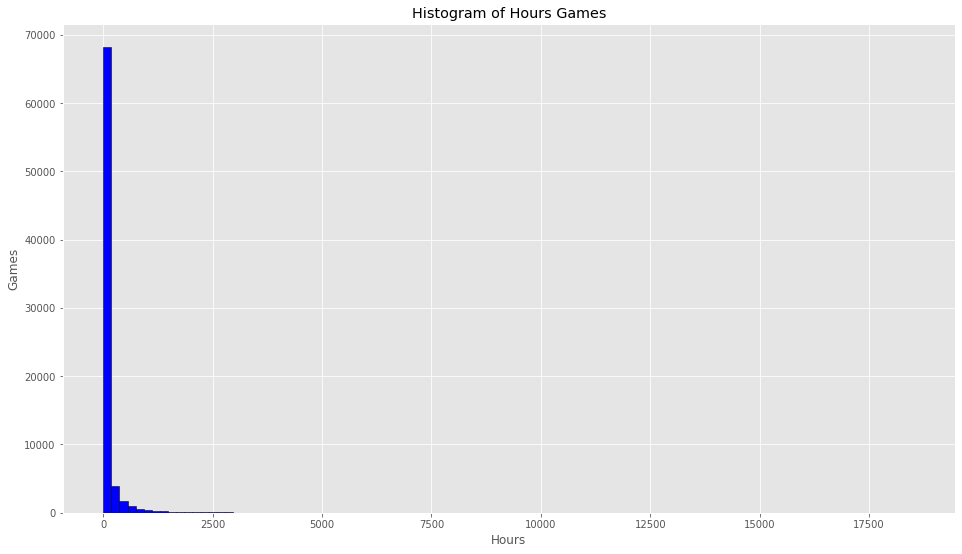

In [49]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib histogram
plt.hist(df1['hours'], color = 'blue', edgecolor = 'black',
         bins = 100)


# Add labels
plt.title('Histogram of Hours Games')
plt.xlabel('Hours')
plt.ylabel('Games')

Observamos que la gran mayoría se concentra en menos de 100 horas de juego. Muy pocos con gran cantidad de horas jugadas, pueden ser outliers.

¿Cómo es la distribución de las calificaciones? Veamos.

Text(0, 0.5, 'Games')

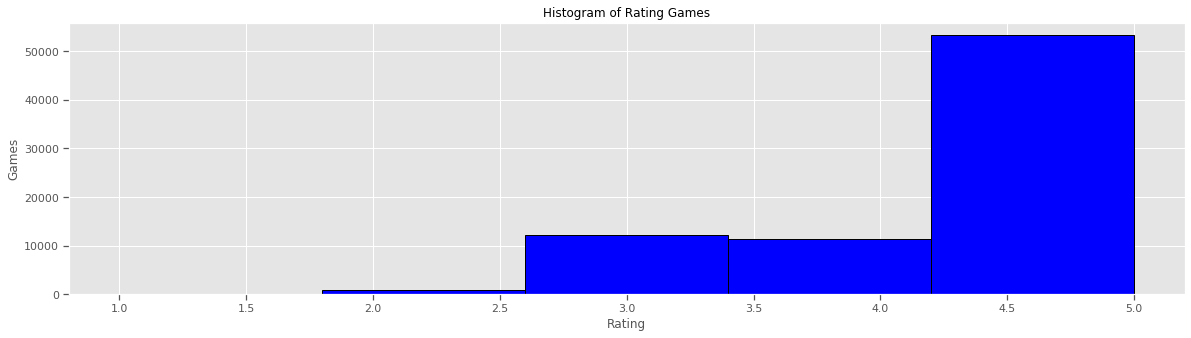

In [50]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook", font_scale=1)
plt.figure(figsize=(20,5))

# matplotlib histogram
plt.hist(df1['sentiment'], color = 'blue', edgecolor = 'black',
         bins = 5)


# Add labels
plt.title('Histogram of Rating Games')
plt.xlabel('Rating')
plt.ylabel('Games')

Observamos que la gran mayoria de los juegos están bien calificados, muy pocos y casi ninguno con bajas calificaciones. Evidencia muy buena experiencia de juego del sitio.

¿Cómo es la distribución del número de calificaciones por usuario?

In [51]:
df_user_rating = df1.groupby('username', as_index = False)[['sentiment']].count()
df_user_rating_desc = df_user_rating.sort_values(['sentiment'],ascending=False).reset_index(drop=True)

In [52]:
df_user_rating_desc.head(20)

,username,sentiment
0,Alex,28
1,Chris,26
2,123,24
3,Jack,19
4,Nick,17
5,Matt,14
6,Tom,13
7,Josh,13
8,Dan,13
9,Bob,12


Ahora sabemos cuales son los usuarios que mas participan en las evaluaciones

Con solo lo anterior no podriamos decir que los que lideran el anterior ranking son los mas activos en el sitio. Si los mas participativos, pero ahora vemos quienes son los usuarios que más tiempo suman en el sitio jugando.

In [53]:
df_user_hours = df1.groupby('username', as_index = False)[['hours']].sum()
df_user_hours_desc = df_user_hours.sort_values(['hours'],ascending=False).reset_index(drop=True)

In [54]:
df_user_hours_desc.head(20)

,username,hours
0,Hertz Donut,18543.3
1,THeNy,14207.8
2,knightgoat,13898.9
3,Snorlax,13610.0
4,benelou,12652.2
5,Postal,10951.4
6,Bryte Darklyt,10769.8
7,Mackan,10317.6
8,Flaws,10243.5
9,seigejet,10192.9


Text(0, 0.5, 'Games')

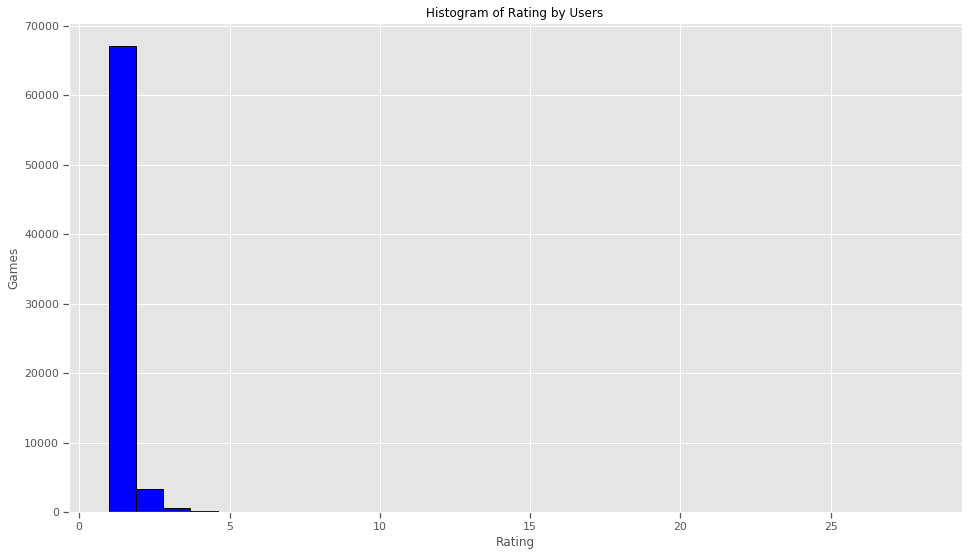

In [55]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib histogram
plt.hist(df_user_rating['sentiment'], color = 'blue', edgecolor = 'black',
         bins = 30)


# Add labels
plt.title('Histogram of Rating by Users')
plt.xlabel('Rating')
plt.ylabel('Games')

Se observa que muy pocos usuarios califican más de 2 peliculas.

¿Cuál es el juego con más calificaciones?¿Cuántas tiene?¿Y el que menos calificaciones tiene?

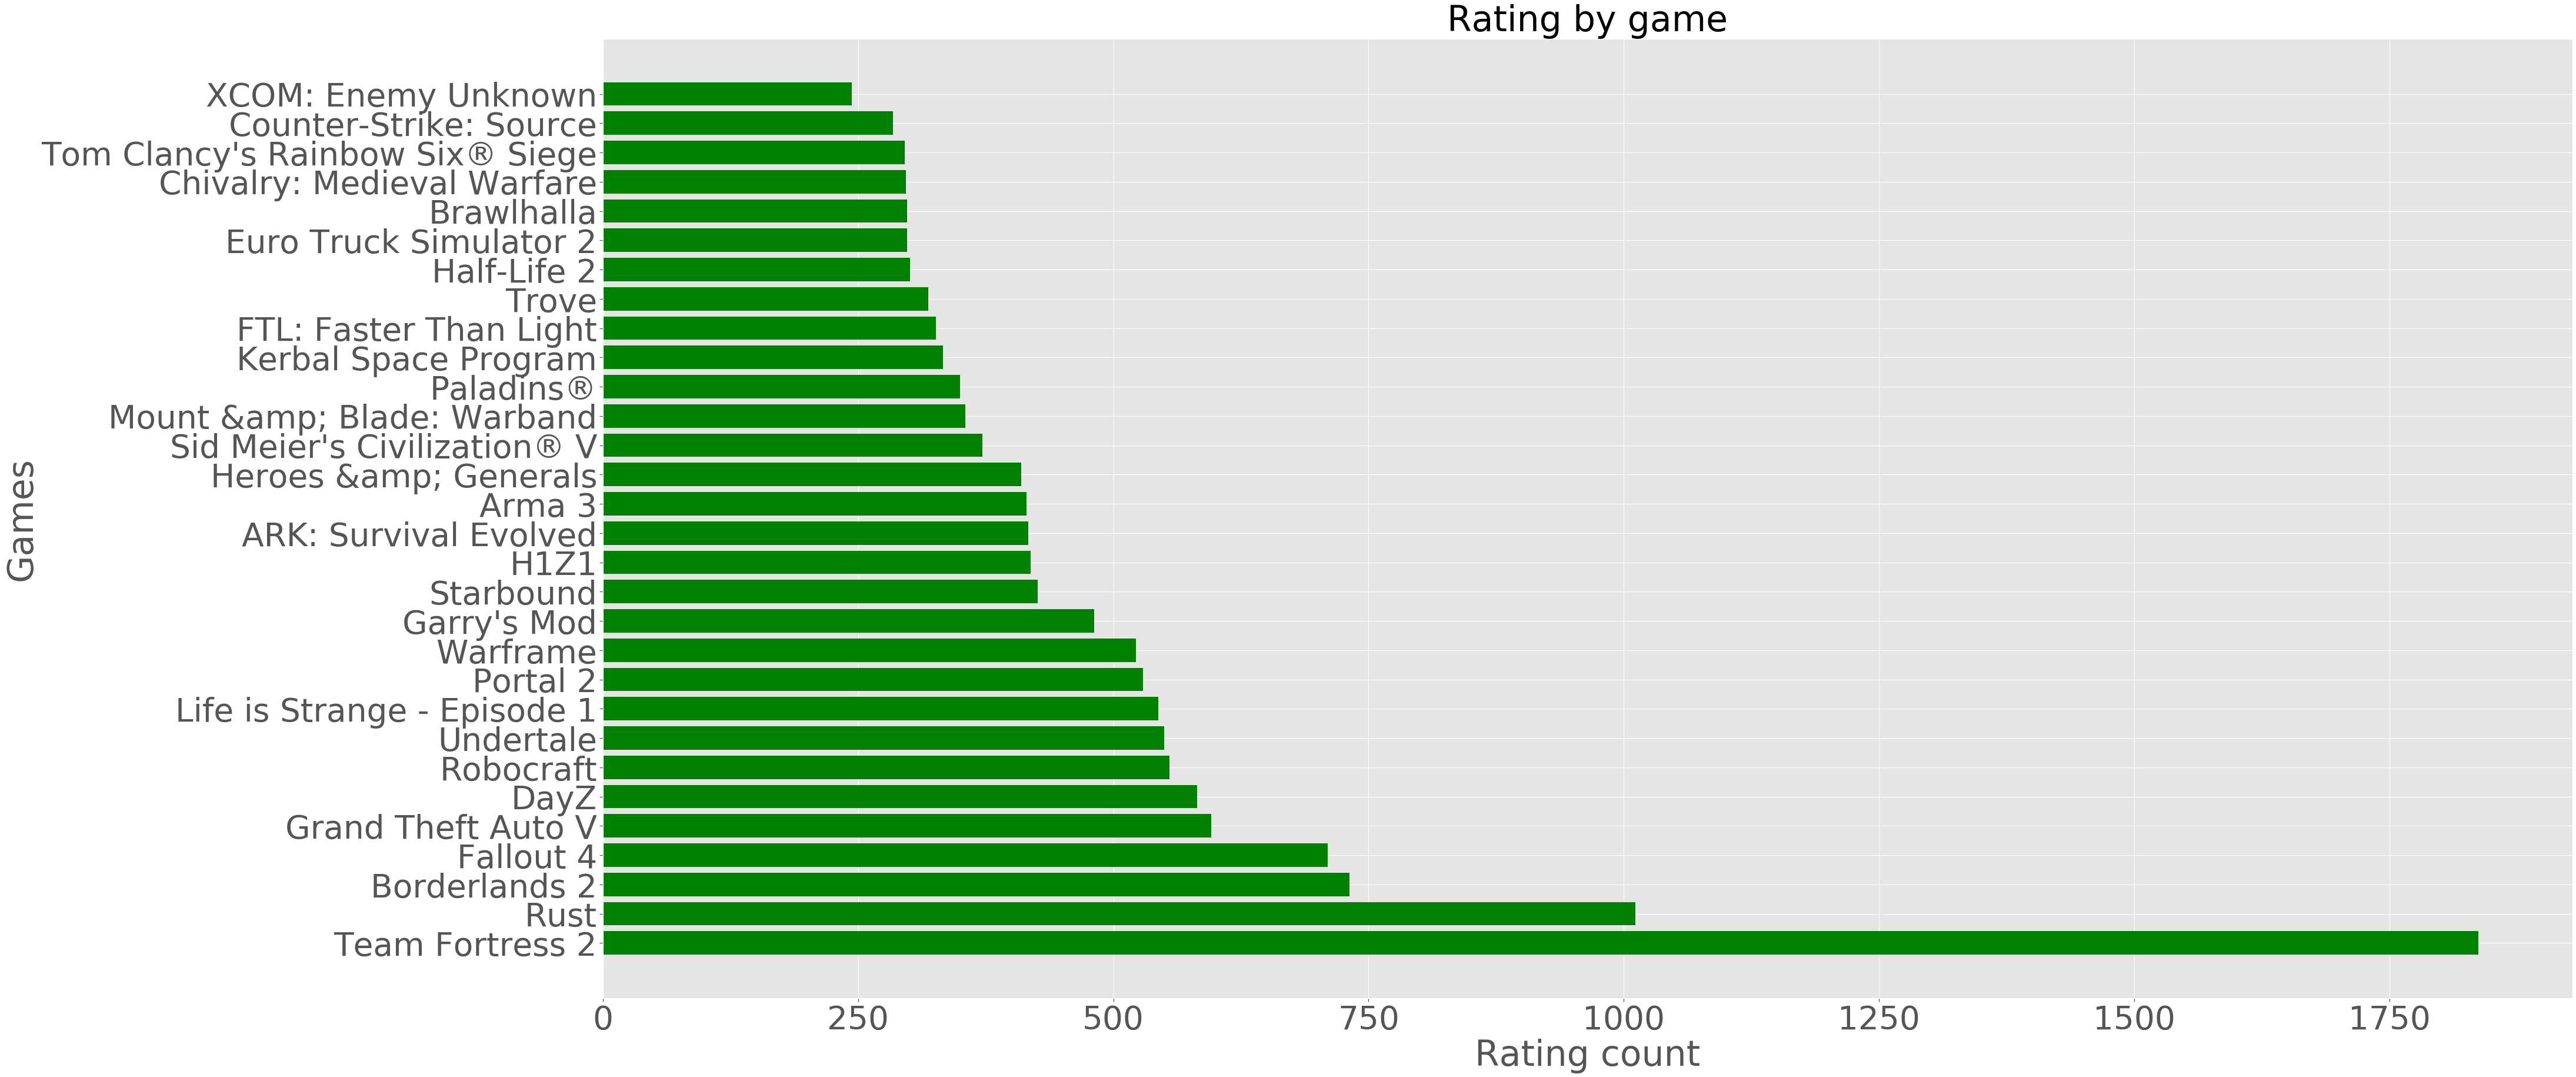

In [56]:
sns.set_context("notebook", font_scale=5)
plt.figure(figsize=(60,30))
df_group_games = df1.groupby('title', as_index = False)[['sentiment']].count()
df_group_games = df_group_games.sort_values(['sentiment'],ascending=False).reset_index(drop=True)
df_group_games=df_group_games.head(30)
x = df_group_games['title']
df_rating = df_group_games['sentiment']
x_pos = [i for i, _ in enumerate(x)]

plt.barh(x_pos, df_rating, color='green')
plt.ylabel("Games")
plt.xlabel("Rating count")
plt.title("Rating by game")

plt.yticks(x_pos, x)

plt.show()

Observamos que unos de los más votados es Team Fortress 2, con un número bastante alto de calificaciones mayor a 1500.

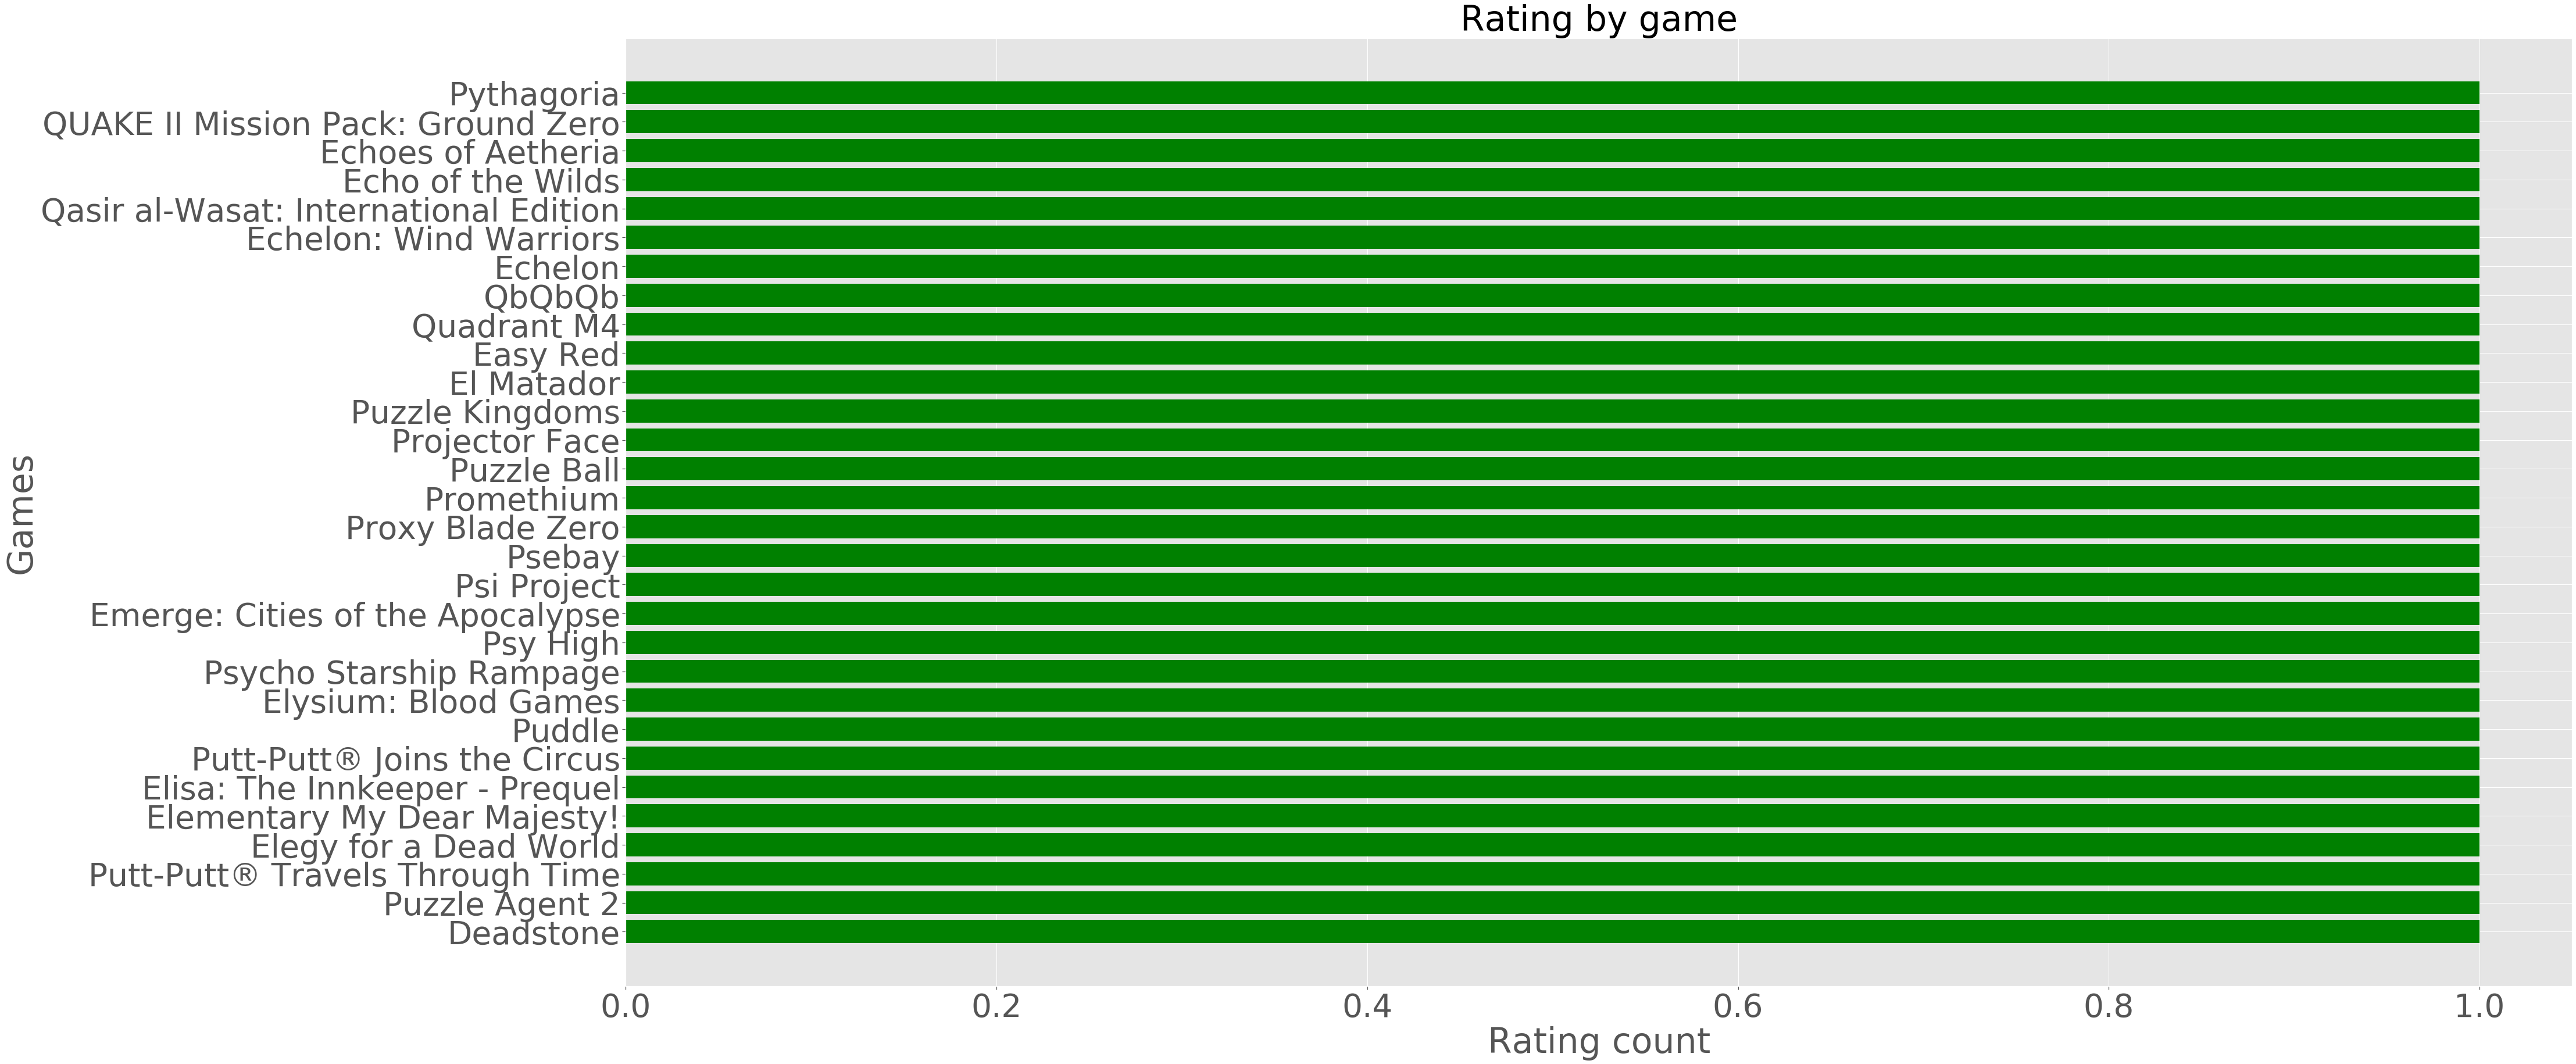

In [57]:
sns.set_context("notebook", font_scale=5)
plt.figure(figsize=(60,30))
df_group_games_desc = df1.groupby('title', as_index = False)[['sentiment']].count()
df_group_games_desc = df_group_games_desc.sort_values(['sentiment'],ascending=True).reset_index(drop=True)
df_group_games_desc=df_group_games_desc.head(30)
x = df_group_games_desc['title']
df_rating = df_group_games_desc['sentiment']
x_pos = [i for i, _ in enumerate(x)]

plt.barh(x_pos, df_rating, color='green')
plt.ylabel("Games")
plt.xlabel("Rating count")
plt.title("Rating by game")

plt.yticks(x_pos, x)

plt.show()

Con los anteriores graficos podemos ver cuales son los mas y menos calificados. Sin embargo no podemos decir que el más votado es el mejor validemos cuales son los mejor calificados, hagamoslo sumando las calificaciones entendiendo que de 1 a 9 entre más alto mayor acumulado positivo tendrá.

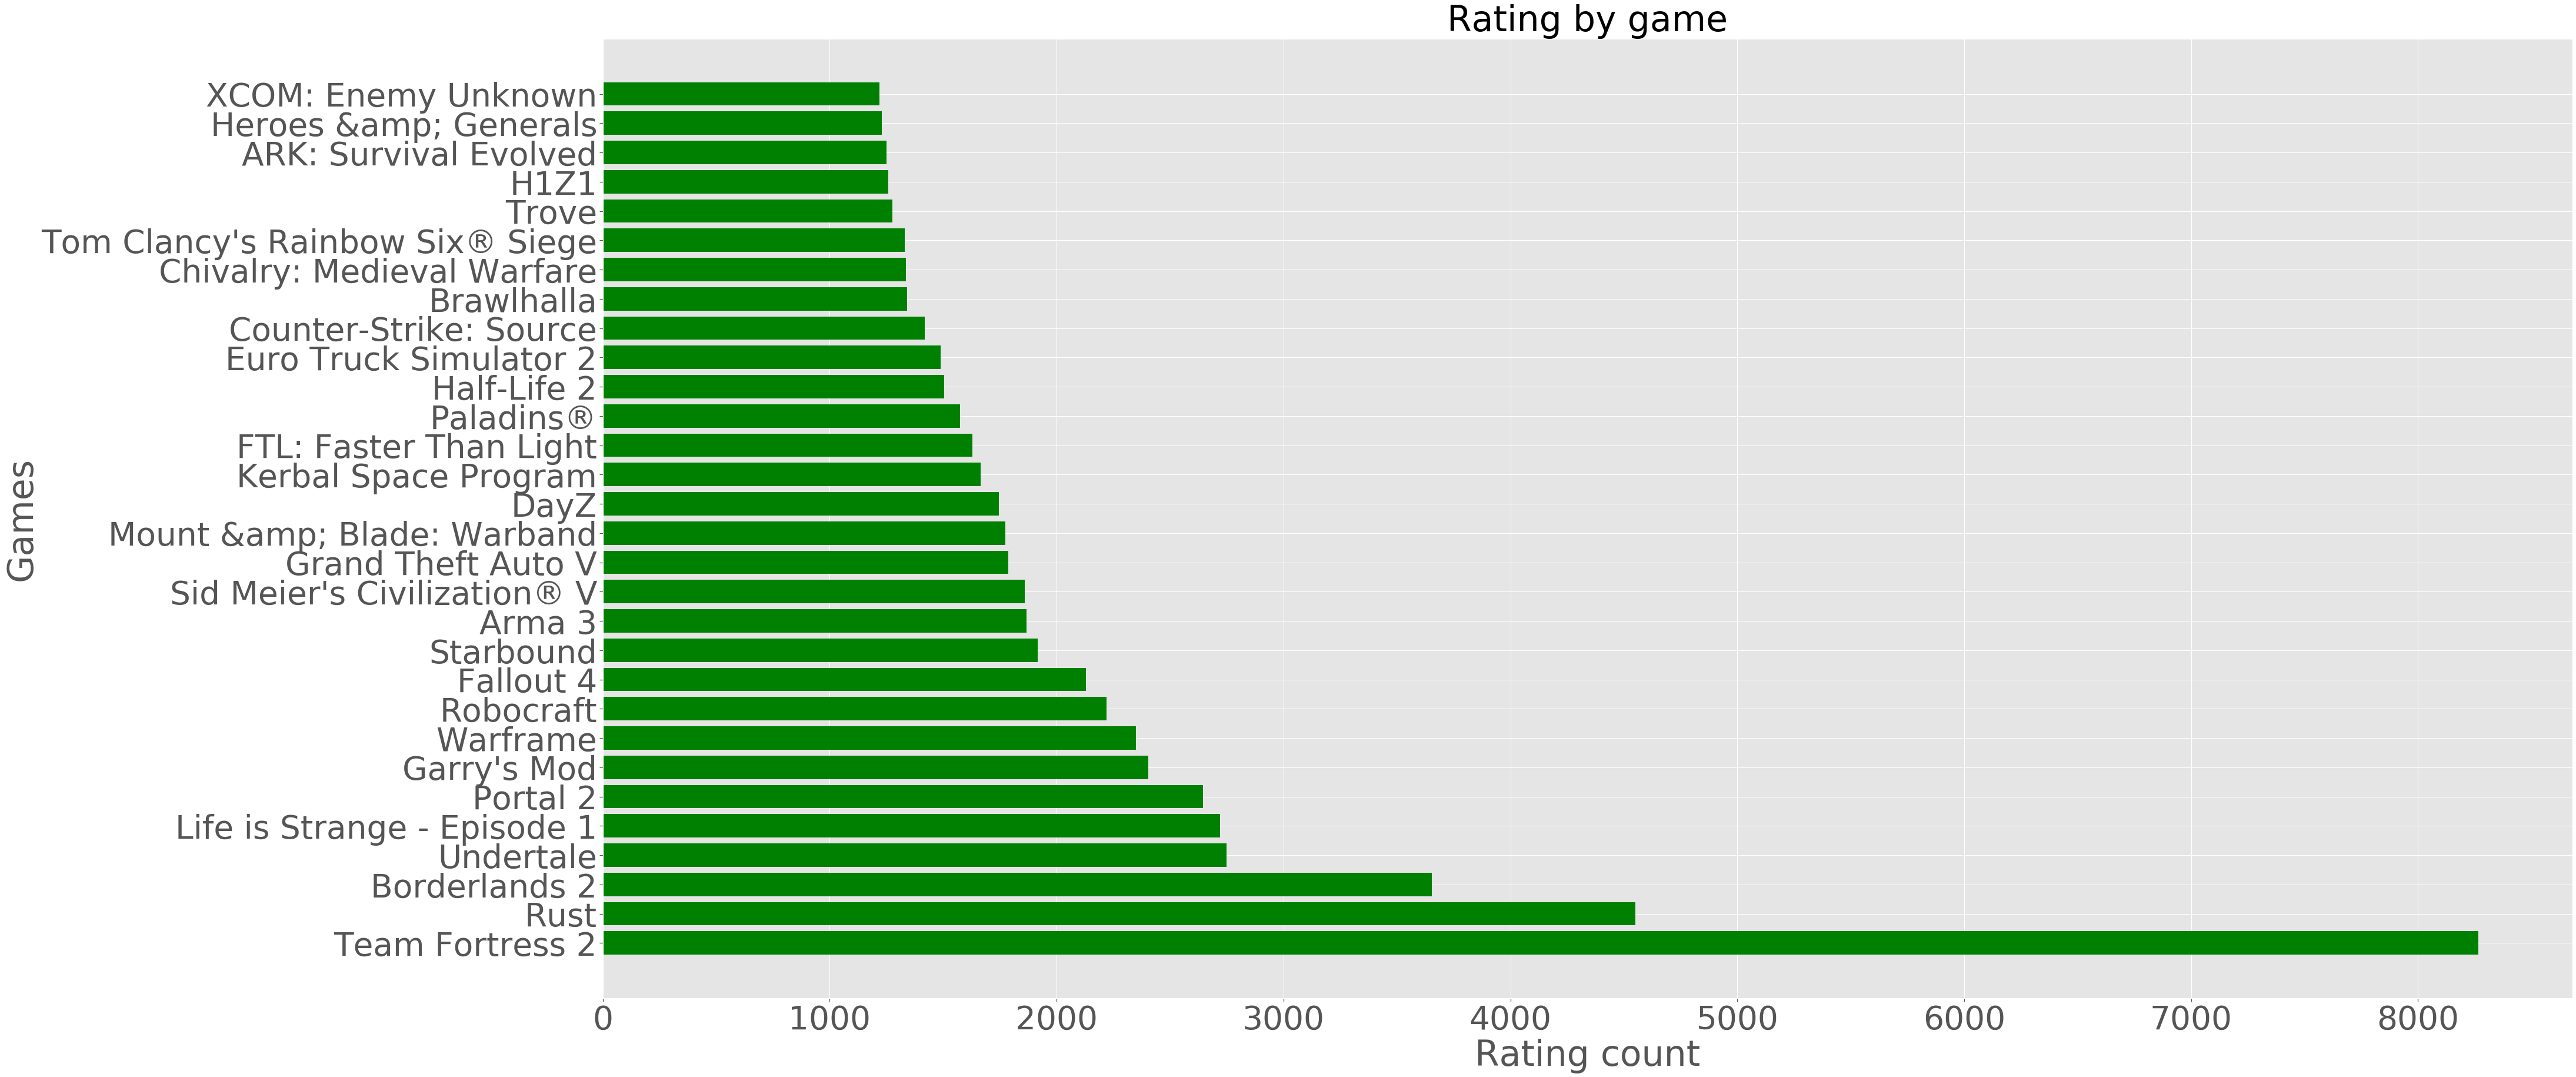

In [58]:
sns.set_context("notebook", font_scale=5)
plt.figure(figsize=(60,30))
df_group_games = df1.groupby('title', as_index = False)[['sentiment']].sum()
df_group_games = df_group_games.sort_values(['sentiment'],ascending=False).reset_index(drop=True)
df_group_games=df_group_games.head(30)
x = df_group_games['title']
df_rating = df_group_games['sentiment']
x_pos = [i for i, _ in enumerate(x)]

plt.barh(x_pos, df_rating, color='green')
plt.ylabel("Games")
plt.xlabel("Rating count")
plt.title("Rating by game")

plt.yticks(x_pos, x)

plt.show()

Muy bien observamos que coincide casi en su totalidad con los más votados.

Analicemos y hagamos limpieza de valores faltantes

In [59]:
df_clear = df1.dropna(axis=0,how='any')

In [60]:
df_clear.shape

(71559, 20)

Revisemos los outliers

Text(0.5, 1.0, 'Outliers en horas por ranking de calificaciones')

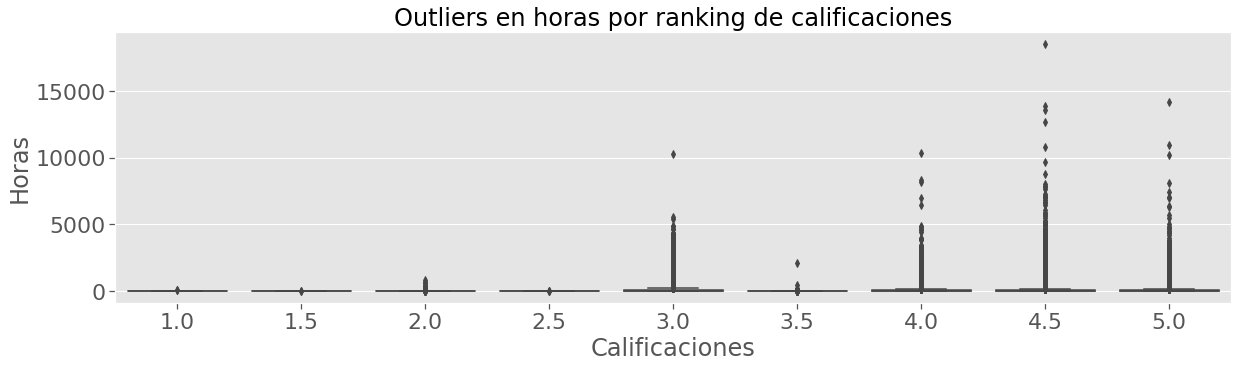

In [61]:
sns.set_context("notebook", font_scale=2)
plt.figure(figsize=(20,5))
sns.boxplot(data = df_clear, y = "hours", x="sentiment")
plt.ylabel("Horas")
plt.xlabel("Calificaciones")
plt.title("Outliers en horas por ranking de calificaciones")

Text(0.5, 1.0, 'Outliers en precio por ranking de calificaciones')

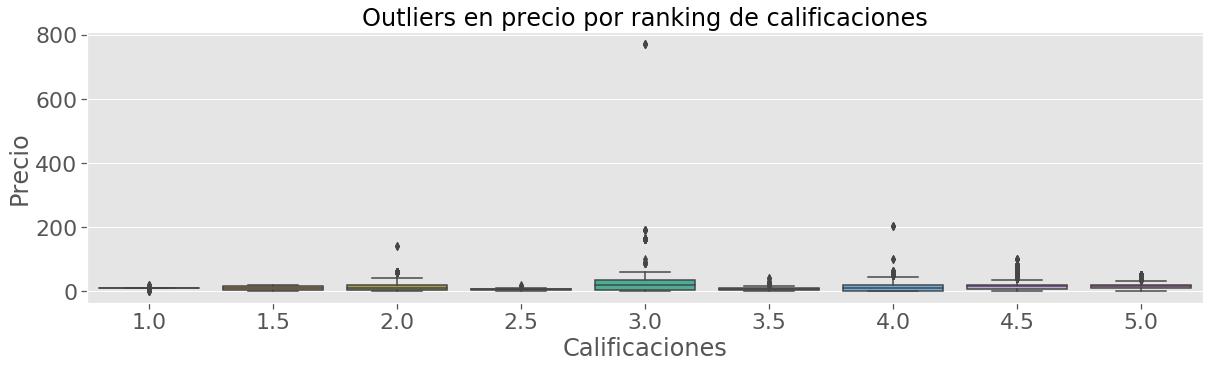

In [62]:
sns.set_context("notebook", font_scale=2)
plt.figure(figsize=(20,5))
sns.boxplot(data = df_clear, y = "price", x="sentiment")
plt.ylabel("Precio")
plt.xlabel("Calificaciones")
plt.title("Outliers en precio por ranking de calificaciones")

In [63]:
df_clear['price'].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

0.0      0.00
0.1      0.00
0.2      4.99
0.3      9.99
0.4      9.99
0.5     14.99
0.6     19.99
0.7     19.99
0.8     24.99
0.9     39.99
1.0    771.71
Name: price, dtype: float64

In [64]:
df_clear['hours'].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

0.0        0.0
0.1        1.2
0.2        3.2
0.3        6.0
0.4       10.3
0.5       16.5
0.6       27.1
0.7       47.1
0.8       92.0
0.9      247.1
1.0    18543.3
Name: hours, dtype: float64

In [65]:
#Funcion para detectar los outliers usando IQR
def detect_outliersIQR(data,columnName):
    
    outliers=[]    

    for n in [1,1.5,2,2.5,3,3.5,4,4.5,5]:    
        Q1 = np.percentile(data[data["sentiment"]==n][columnName], 25, interpolation = 'midpoint') 
        
        Q3 = np.percentile(data[data["sentiment"]==n][columnName], 75, interpolation = 'midpoint')         
        IQR = Q3 - Q1
        low_lim = Q1 - 1.5 * IQR 
        up_lim = Q3 + 1.5 * IQR     
    

    
        for i in data[data["sentiment"]==n].itertuples():
            if ((i[1] > up_lim) or (i[1] < low_lim)):
                outliers.append(i[2])
    return outliers

In [66]:
df_clear_filtered= df_clear.copy()

In [67]:
df_outliers = detect_outliersIQR(df_clear_filtered[['price','unique_id','sentiment']],'price')
df_clear_filtered = df_clear_filtered[~df_clear_filtered['unique_id'].isin(df_outliers)]

In [68]:
df_outliers = detect_outliersIQR(df_clear_filtered[['hours','unique_id','sentiment']],'hours')
df_clear_filtered = df_clear_filtered[~df_clear_filtered['unique_id'].isin(df_outliers)]

Text(0.5, 1.0, 'Outliers en horas por ranking de calificaciones sin Outliers')

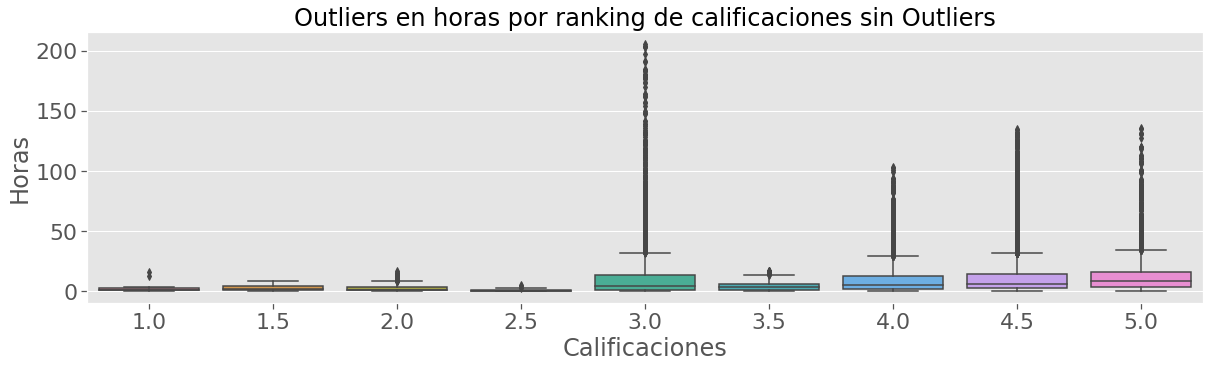

In [69]:
sns.set_context("notebook", font_scale=2)
plt.figure(figsize=(20,5))
sns.boxplot(data = df_clear_filtered, y = "hours", x="sentiment")
plt.ylabel("Horas")
plt.xlabel("Calificaciones")
plt.title("Outliers en horas por ranking de calificaciones sin Outliers")

Text(0.5, 1.0, 'Outliers en precio por ranking de calificaciones sin Outliers')

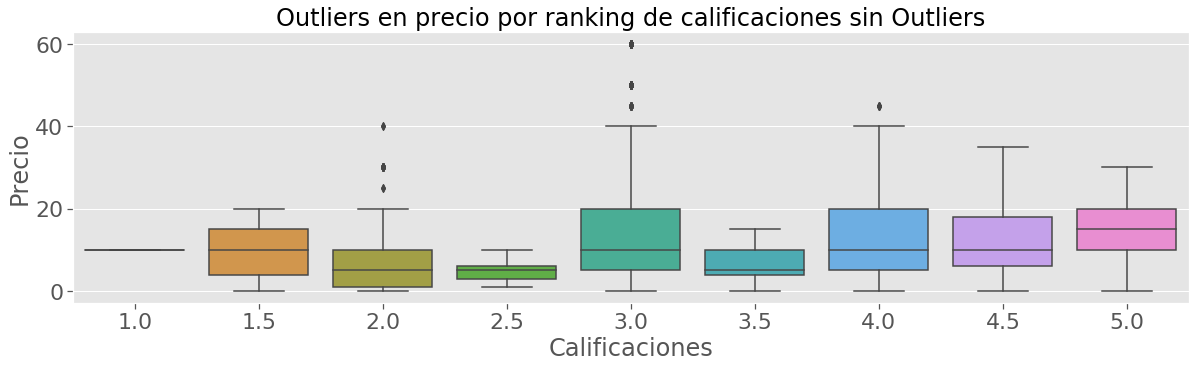

In [70]:
sns.set_context("notebook", font_scale=2)
plt.figure(figsize=(20,5))
sns.boxplot(data = df_clear_filtered, y = "price", x="sentiment")
plt.ylabel("Precio")
plt.xlabel("Calificaciones")
plt.title("Outliers en precio por ranking de calificaciones sin Outliers")

Veamos nuevamente el ranking de juegos mejor votados por usuarios luego de hacer tratamiento de valores faltantes y eliminación de outliers

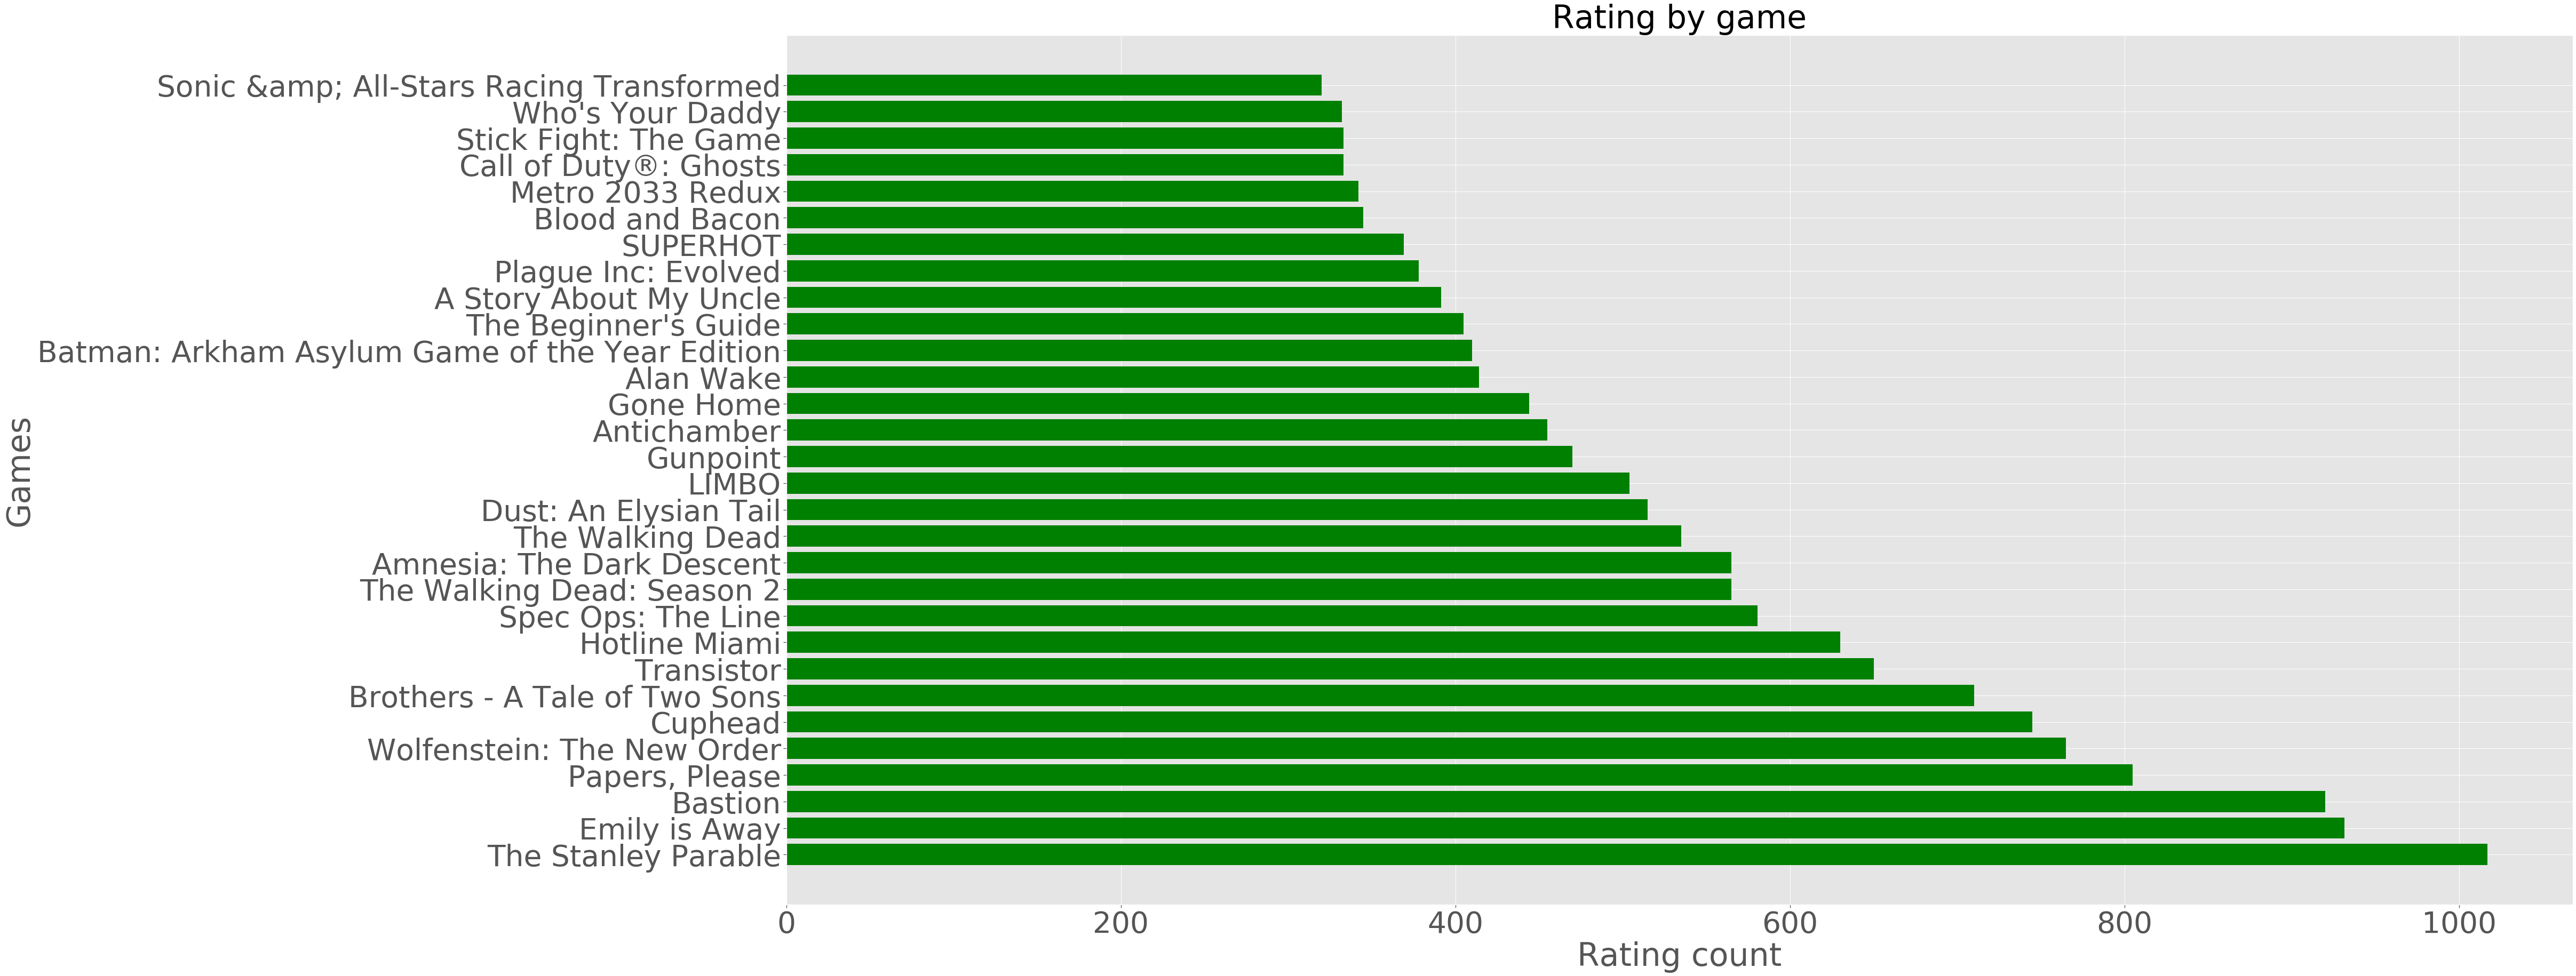

In [71]:
sns.set_context("notebook", font_scale=5)
plt.figure(figsize=(60,30))
df_group_games = df_clear_filtered.groupby('title', as_index = False)[['sentiment']].sum()
df_group_games = df_group_games.sort_values(['sentiment'],ascending=False).reset_index(drop=True)
df_group_games=df_group_games.head(30)
x = df_group_games['title']
df_rating = df_group_games['sentiment']
x_pos = [i for i, _ in enumerate(x)]

plt.barh(x_pos, df_rating, color='green')
plt.ylabel("Games")
plt.xlabel("Rating count")
plt.title("Rating by game")

plt.yticks(x_pos, x)

plt.show()

Nuestro ranking ha variado un poco luego del tratamiento de valores faltantes y outliers.

Hagamos un diagrama de correlación para identificar pares

In [72]:
df_numerico_col = (df_clear_filtered.dtypes == float) | (df_clear_filtered.dtypes == int ) | (df_clear_filtered.dtypes == np.int64 ) 
df_numerico_col.index
df_numerico_col = [c for c in df_numerico_col.index if df_numerico_col[c]]
df_numerico_col

['price', 'product_id', 'sentiment', 'hours', 'products', 'unique_id']

In [73]:
df_clear_num = df_clear_filtered[['price', 'product_id', 'sentiment', 'hours', 'products', 'unique_id']]
df_clear_num.head()

,price,product_id,sentiment,hours,products,unique_id
1,9.99,282010,4.5,6.1,135.0,2312070407288726401
2,9.99,282010,4.5,2.7,403.0,2312070407288726401
124,6.99,1630,4.5,5.7,37.0,-7256972984279321967
125,6.99,1630,4.5,0.3,33.0,-7256972984279321967
126,6.99,1630,4.5,0.3,206.0,-7256972984279321967


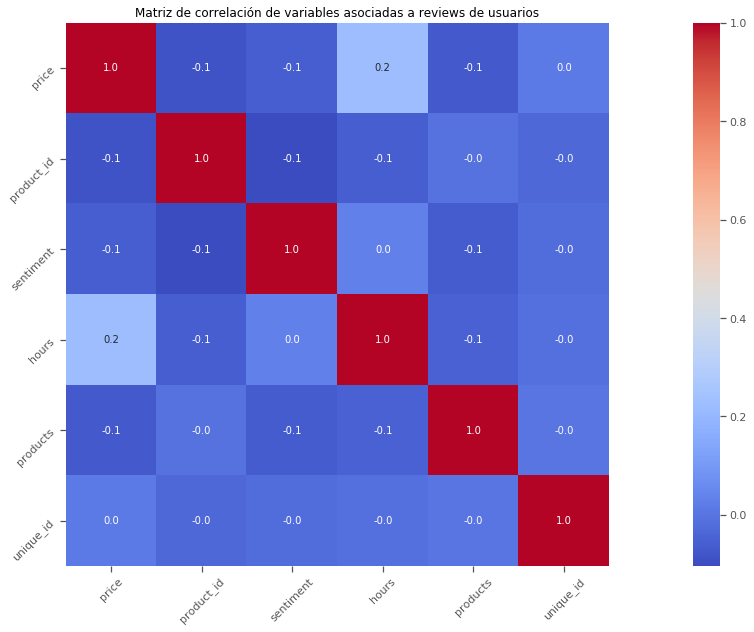

In [74]:
sns.set_context("notebook", font_scale=1)
plt.figure(figsize=(30,10))

df_clear_num_cor = df_clear_num.corr()

sns.heatmap(df_clear_num_cor, cbar = True,  square = True, annot=True, fmt= '.1f',annot_kws={'size': 10},
           xticklabels= df_clear_num_cor.columns, 
           yticklabels= df_clear_num_cor.columns,
           cmap= 'coolwarm')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.title("Matriz de correlación de variables asociadas a reviews de usuarios")
plt.show()#fmt: Cantidad de decimales

Se observa a simple vista que no hay mucha correlación entre las variables. Quizas esperaba que las horas de juegos tubiesen correlación con la calificación.

Text(0.5, 1.08, 'Pairplot para visualizar relación y proporcionalidad de variables')

<Figure size 2160x720 with 0 Axes>

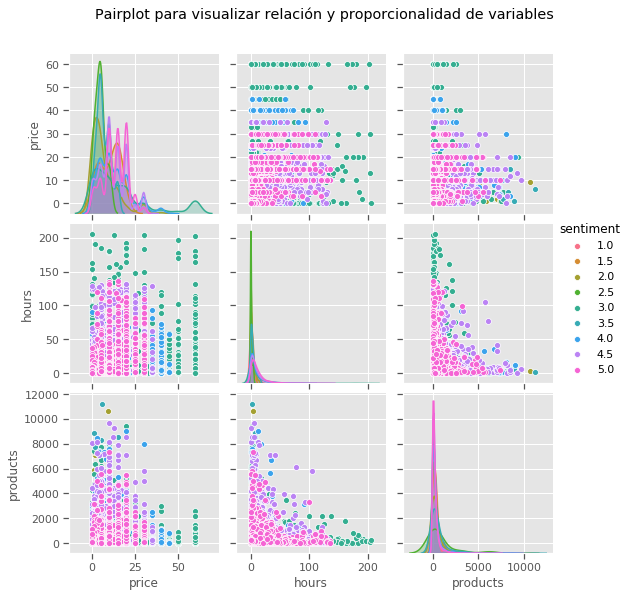

In [75]:
sns.set_context("notebook", font_scale=1)
plt.figure(figsize=(30,10))

g = sns.pairplot(df_clear_num[['price','hours','sentiment','products']], hue="sentiment")
g.fig.suptitle("Pairplot para visualizar relación y proporcionalidad de variables", y=1.08)

Se observa que gran cantidad de juegos son bien calificados, tambien se observa que los juegos mas votados no son realmente los más jugados por los usuarios, se observa que muchos juegos evaluados medianamente bien son en los que los usuarios invierten más horas jugando.

### Parte B - Modelo de Machine Learning. 
En esta sección deberás aplicar las técnicas de Machine Learning aprendidas para crear un modelo predictivo a partir del dataset provisto.

#### Checklist de evaluación
Debes evaluar correctamente el modelo que realices. Esto implica un correcto manejo de datos de Train y Test, elegir una métrica apropiada y justificar su elección, y comparar los resultados contra un modelo benchmark.

Puedes aplicar más de una de las técnicas vistas para crear tus modelos. Pero ten en cuenta que es preferible un modelo bien hecho (apropiada transformación de datos, optimización de hiperparámetros y análisis de sus resultados) que muchos modelos a medias. En caso de entrenar más de un modelo, debes comparar sus resultados y justificar cuál elegirías.

Si el modelo lo permite, debes explorar qué información utiliza para predecir e interpretar ese resultado. ¿Coincide con lo que esperabas a partir de tu experiencia con el dataset?

#### Se implementará modelo definido por usuario (Matriz de Similitud: Distancias por Coseno) sin usar librerias predefinidas (Modelo Benchmark)

In [113]:
n_users = df_user_rating_desc.head(100).username.unique()
df_users = pd.DataFrame(data=n_users, columns=["username"])
df_users

,username
0,Alex
1,Chris
2,123
3,Jack
4,Nick
...,...
95,Nobody
96,Harry
97,chiken
98,Redrusty66


In [114]:
df_games = data_games[['product_id','title']]
df_games.head()

,product_id,title
0,761140,Lost Summoner Kitty
1,643980,Ironbound
2,670290,Real Pool 3D - Poolians
3,767400,弹炸人2222
4,773570,NaN


In [174]:
df_games.shape

(32135, 2)

In [115]:
df_ratings = df_ml[['product_id','Rating','username']]
df_ratings.rename(columns = {'Rating':'rating'}, inplace = True)
df_ratings.rename(columns = {'username':'userId'}, inplace = True)
df_ratings.head()

,product_id,rating,userId
1,282010,4.5,Hit_Pepns
2,282010,4.5,rohonnag
124,1630,4.5,Executor
125,1630,4.5,Sir Ronald Doge II
126,1630,4.5,The Denizen


In [118]:
df_ratings2 = df_ratings[df_ratings['userId'].isin(df_users['username'])]

In [119]:
df_ratings2

,product_id,rating,userId
708,3980,4.0,Sarkoth
814,9010,4.5,Hanzo
1182,13240,5.0,Josh
1262,17330,4.5,Razor
1277,17300,4.5,...
...,...,...,...
73323,6000,4.5,Drake
74283,15190,4.5,Mouse
76323,8080,3.0,Dad
76356,6850,4.5,Adrian


Ahora crearemos la matriz en la que cruzamos todos los usuarios con todos los juegos.

In [120]:
df_matrix = pd.pivot_table(df_ratings2, values='rating', index='userId', columns='product_id').fillna(0)
df_matrix

product_id,50,3980,6000,6850,8080,9010,10130,10150,11450,12100,...,557860,558990,561590,582280,585690,608800,623940,635320,657790,665360
userId,,,,,,,,,,,,,,,,,,,,,
( ͡° ͜ʖ ͡°),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
..,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
:),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ok,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yang racer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0
yuru,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Vemos que rellenamos los “huecos” de la matriz con ceros. Y esos ceros serán los que deberemos reemplazar con las recomendaciones.

Veamos el porcentaje de sparcity que tenemos:

In [121]:
ratings = df_matrix.values
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))


Sparsity: 1.26%


Esto serán muchos “ceros” que rellenar (predecir)…

Dividimos en Train y Test set
Separamos en train y test para -más adelante- poder medir la calidad de nuestras recomendaciones.

In [163]:
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import mean_squared_error


In [123]:
ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [124]:
ratings_train, ratings_test = train_test_split(ratings, test_size = 0.2, shuffle=False, random_state=42)
print(ratings_train.shape)
print(ratings_test.shape)

(73, 249)
(19, 249)


Matriz de Similitud: Distancias por Coseno
Ahora calculamos en una nueva matriz la similitud entre usuarios.

In [125]:
import sklearn

In [126]:
sim_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(ratings)
print(sim_matrix.shape)


(92, 92)


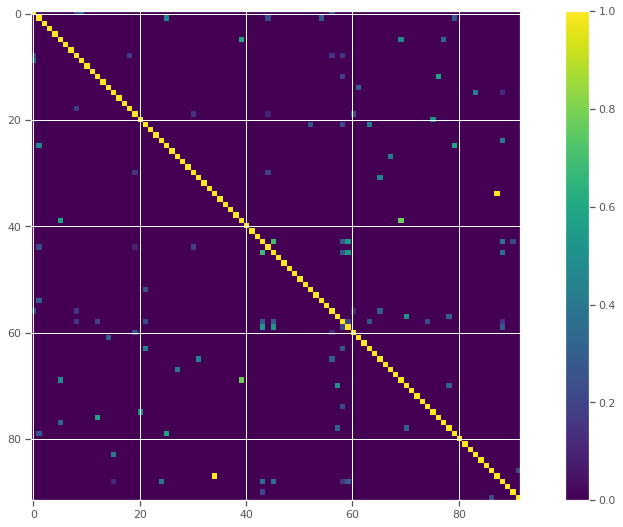

In [127]:
plt.imshow(sim_matrix);
plt.colorbar()
plt.show()

In [130]:
#separar las filas y columnas de train y test
sim_matrix_train = sim_matrix[0:73,0:73]
sim_matrix_test = sim_matrix[73:92,73:92]
print(sim_matrix_train.shape)
print(sim_matrix_test.shape)

(73, 73)
(19, 19)


Predicciones (las recomendaciones!)

In [131]:
users_predictions = sim_matrix_train.dot(ratings_train) / np.array([np.abs(sim_matrix_train).sum(axis=1)]).T


In [132]:
users_predictions.shape


(73, 249)

Matriz de similitud entre los usuarios (distancia del coseno -vectores-)

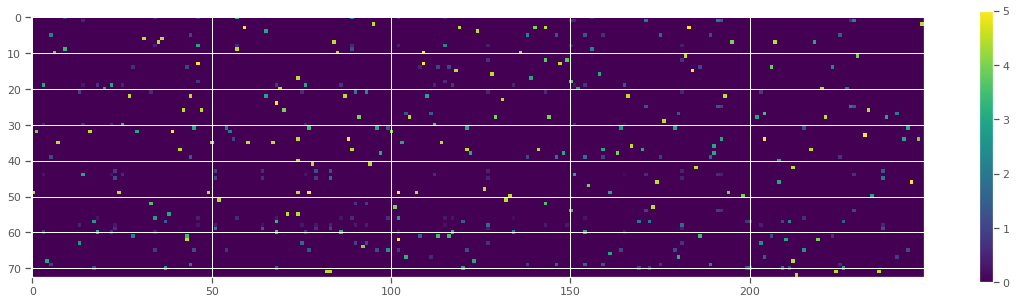

In [133]:
plt.rcParams['figure.figsize'] = (20.0, 5.0)
plt.imshow(users_predictions);
plt.colorbar()
plt.show()

In [135]:
df_users

,username
0,Alex
1,Chris
2,123
3,Jack
4,Nick
...,...
95,Nobody
96,Harry
97,chiken
98,Redrusty66


####  Probemos con un usuario

In [215]:
USUARIO_EJEMPLO = 'Alex' # debe existir en nuestro dataset de train!
usuario_ver = df_users[df_users['username']==USUARIO_EJEMPLO].index.values.astype(int)[0]
user0=users_predictions.argsort()[usuario_ver]
# Veamos los dos recomendados con mayor puntaje para este usuario
for i, aRepo in enumerate(user0[-2:]):
    selRepo = df_games.iloc[aRepo]
    print(selRepo['title'], selRepo['title'], 'puntaje:', users_predictions[usuario_ver][aRepo])


QUAKE Mission Pack 1: Scourge of Armagon QUAKE Mission Pack 1: Scourge of Armagon puntaje: 2.4734802115403607
The Ship: Single Player The Ship: Single Player puntaje: 3.347960840272117


#### Evaluemos el modelo

In [212]:
def get_mse(preds, actuals):
    if preds.shape[1] != actuals.shape[1]:
        actuals = actuals.T
    preds = preds[actuals.nonzero()].flatten()
    actuals = actuals[actuals.nonzero()].flatten()
    return mean_squared_error(preds, actuals)

In [213]:
get_mse(users_predictions, ratings_train)


1.0252616594551556

In [214]:
# Realizo las predicciones para el test set
users_predictions_test = sim_matrix.dot(ratings) / np.array([np.abs(sim_matrix).sum(axis=1)]).T
users_predictions_test = users_predictions_test[73:92,:]

get_mse(users_predictions_test, ratings_test)

15.900921148615145

Observamos que en el conjunto de entrenamiento el resultado es bueno pero en test no es tan preciso el modelo. A continuación implementaremos nuestro modelo usando la libreria SVD tratando de mejorar los resultados de modelo benchmark.

#### Implementación de modelo usando filtro colaborativo (Collaborative Filtering)

In [220]:
from surprise.model_selection import train_test_split
from surprise import Dataset
from surprise import Reader

Primero, llevamos el dataset al formato que le gusta a la biblioteca.

In [221]:
reader = Reader()

In [222]:
df_clear_filtered.head()

,publisher,genres,title,url,release_date,tags,reviews_url,specs,price,game_earlyaccess,product_id,developer,sentiment,username,hours,products,date,text,early_access,unique_id
1,Stainless Games Ltd,"['Action', 'Indie', 'Racing']",Carmageddon Max Pack,http://store.steampowered.com/app/282010/Carma...,1997-06-30,"['Racing', 'Action', 'Classic', 'Indie', 'Gore...",http://steamcommunity.com/app/282010/reviews/?...,"['Single-player', 'Multi-player', 'Steam Tradi...",9.99,False,282010,Stainless Games Ltd,4.5,Hit_Pepns,6.1,135.0,2015-04-09,"A legend. The game, which in nice, immaculate ...",False,2312070407288726401
2,Stainless Games Ltd,"['Action', 'Indie', 'Racing']",Carmageddon Max Pack,http://store.steampowered.com/app/282010/Carma...,1997-06-30,"['Racing', 'Action', 'Classic', 'Indie', 'Gore...",http://steamcommunity.com/app/282010/reviews/?...,"['Single-player', 'Multi-player', 'Steam Tradi...",9.99,False,282010,Stainless Games Ltd,4.5,rohonnag,2.7,403.0,2014-07-11,This game has nostalgia written all over it! I...,False,2312070407288726401
124,Strategy First,['Strategy'],Disciples II: Rise of the Elves,http://store.steampowered.com/app/1630/Discipl...,2006-07-06,"['Strategy', 'Turn-Based Strategy', 'Fantasy',...",http://steamcommunity.com/app/1630/reviews/?br...,"['Single-player', 'Multi-player', 'Co-op']",6.99,False,1630,Strategy First,4.5,Executor,5.7,37.0,2017-01-17,Remains a very nice game . But is still useles...,False,-7256972984279321967
125,Strategy First,['Strategy'],Disciples II: Rise of the Elves,http://store.steampowered.com/app/1630/Discipl...,2006-07-06,"['Strategy', 'Turn-Based Strategy', 'Fantasy',...",http://steamcommunity.com/app/1630/reviews/?br...,"['Single-player', 'Multi-player', 'Co-op']",6.99,False,1630,Strategy First,4.5,Sir Ronald Doge II,0.3,33.0,2016-07-21,"ok i bought this game and just installed it, b...",False,-7256972984279321967
126,Strategy First,['Strategy'],Disciples II: Rise of the Elves,http://store.steampowered.com/app/1630/Discipl...,2006-07-06,"['Strategy', 'Turn-Based Strategy', 'Fantasy',...",http://steamcommunity.com/app/1630/reviews/?br...,"['Single-player', 'Multi-player', 'Co-op']",6.99,False,1630,Strategy First,4.5,The Denizen,0.3,206.0,2013-12-25,My friend says it's a good game so why not.,False,-7256972984279321967


In [223]:
df_ml = df_clear_filtered[['title','genres','price','product_id','sentiment','username','hours','text']]

In [224]:
df_ml.head()

,title,genres,price,product_id,sentiment,username,hours,text
1,Carmageddon Max Pack,"['Action', 'Indie', 'Racing']",9.99,282010,4.5,Hit_Pepns,6.1,"A legend. The game, which in nice, immaculate ..."
2,Carmageddon Max Pack,"['Action', 'Indie', 'Racing']",9.99,282010,4.5,rohonnag,2.7,This game has nostalgia written all over it! I...
124,Disciples II: Rise of the Elves,['Strategy'],6.99,1630,4.5,Executor,5.7,Remains a very nice game . But is still useles...
125,Disciples II: Rise of the Elves,['Strategy'],6.99,1630,4.5,Sir Ronald Doge II,0.3,"ok i bought this game and just installed it, b..."
126,Disciples II: Rise of the Elves,['Strategy'],6.99,1630,4.5,The Denizen,0.3,My friend says it's a good game so why not.


In [225]:
df_ml.rename(columns = {'sentiment':'Rating'}, inplace = True)

In [226]:
N_filas = 50000 # Limitamos el dataset a N_filas

data = Dataset.load_from_df(df_ml[['username','product_id','Rating']][:N_filas], reader)

In [227]:
trainset, testset = train_test_split(data, test_size=.25)

Vamos a entrenar un algoritmo SVD

In [228]:
from surprise import SVD
algo = SVD()

Entrenamos sobre el trainset

In [229]:
algo.fit(trainset)

Y predecimos sobre el testset. 

In [230]:
predictions = algo.test(testset)

In [231]:
predictions[1]

Prediction(uid='vgthesis', iid=256460, r_ui=4.5, est=4.238909788517529, details={'was_impossible': False})

si queremos predecir para un usuario y un juego en particular, usamos la función predict

In [232]:
algo.predict('Alex',1630)

Prediction(uid='Alex', iid=1630, r_ui=None, est=4.280525144141437, details={'was_impossible': False})

Exploremos un usuario, veamos cuáles juegos le gustaron y cuáles les recomienda el sistema.

In [233]:
usuario = 'Alex'
rating = 3.5   # le pedimos peliculas a las que haya puesto 4 o 5 estrellas
df_user = df_ml[(df_ml['username'] == usuario) & (df_ml['Rating'] >= rating)]
df_user = df_user.reset_index(drop=True)


Juegos que le gustaron

In [234]:
df_user

,title,genres,price,product_id,Rating,username,hours,text
0,Electronic Super Joy,"['Action', 'Indie']",7.99,244870,4.5,Alex,14.8,"I enjoy platformers, but none is more brutal y..."
1,Destination Sol,"['Action', 'Free to Play', 'Indie', 'RPG']",0.00,342980,4.0,Alex,6.1,pew pew pew in space !!!
2,Guns of Icarus Alliance,"['Action', 'Adventure', 'Indie', 'Simulation']",14.99,608800,4.5,Alex,42.5,Great game. 10/10.
3,Dead Age,"['Action', 'Adventure', 'Casual', 'Indie', 'RP...",14.99,363930,4.5,Alex,75.0,A nice little game with good replay value. Rec...
4,A Story About My Uncle,"['Adventure', 'Casual', 'Indie']",12.99,278360,4.5,Alex,2.1,"Amazing game. Only one flaw, the ending. I'm n..."
5,Brothers - A Tale of Two Sons,"['Action', 'Adventure', 'Indie']",14.99,225080,5.0,Alex,7.8,"Glad I took the time to place this. Sure, the ..."
6,Shank 2,"['Action', 'Adventure', 'Indie']",9.99,102840,4.5,Alex,5.4,Shank 1 isn't a masterpiece. It's a 7/10 for m...


Creamos donde vamos a guardar las recomendaciones

In [235]:
data_games_master = data_games[['product_id','title','genres','price','specs']]

In [236]:
recomendaciones_usuario = data_games_master =data_games_master.copy()
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()

(32135, 5)


,product_id,title,genres,price,specs
0,761140,Lost Summoner Kitty,"[Action, Casual, Indie, Simulation, Strategy]",4.99,[Single-player]
1,643980,Ironbound,"[Free to Play, Indie, RPG, Strategy]",Free To Play,"[Single-player, Multi-player, Online Multi-Pla..."
2,670290,Real Pool 3D - Poolians,"[Casual, Free to Play, Indie, Simulation, Sports]",Free to Play,"[Single-player, Multi-player, Online Multi-Pla..."
3,767400,弹炸人2222,"[Action, Adventure, Casual]",0.99,[Single-player]
4,773570,NaN,NaN,2.99,"[Single-player, Full controller support, HTC V..."


Sacamos del dataframe todos los juegos que ya sabemos que jugo

In [237]:
usuario_vistas = df_ml[df_ml['username'] == usuario]
print(usuario_vistas.shape)
usuario_vistas.head()

(8, 8)


,title,genres,price,product_id,Rating,username,hours,text
8757,Memento Mori,['Adventure'],12.99,200490,3.0,Alex,6.7,"Good plot, relies heavily on text. It was enjo..."
10065,Electronic Super Joy,"['Action', 'Indie']",7.99,244870,4.5,Alex,14.8,"I enjoy platformers, but none is more brutal y..."
16288,Destination Sol,"['Action', 'Free to Play', 'Indie', 'RPG']",0.00,342980,4.0,Alex,6.1,pew pew pew in space !!!
34317,Guns of Icarus Alliance,"['Action', 'Adventure', 'Indie', 'Simulation']",14.99,608800,4.5,Alex,42.5,Great game. 10/10.
35757,Dead Age,"['Action', 'Adventure', 'Casual', 'Indie', 'RP...",14.99,363930,4.5,Alex,75.0,A nice little game with good replay value. Rec...


In [238]:
recomendaciones_usuario2 = recomendaciones_usuario[~recomendaciones_usuario['product_id'].isin(usuario_vistas['product_id'])]

In [239]:
recomendaciones_usuario2 = recomendaciones_usuario2.reset_index()
recomendaciones_usuario2.head()

,index,product_id,title,genres,price,specs
0,0,761140,Lost Summoner Kitty,"[Action, Casual, Indie, Simulation, Strategy]",4.99,[Single-player]
1,1,643980,Ironbound,"[Free to Play, Indie, RPG, Strategy]",Free To Play,"[Single-player, Multi-player, Online Multi-Pla..."
2,2,670290,Real Pool 3D - Poolians,"[Casual, Free to Play, Indie, Simulation, Sports]",Free to Play,"[Single-player, Multi-player, Online Multi-Pla..."
3,3,767400,弹炸人2222,"[Action, Adventure, Casual]",0.99,[Single-player]
4,4,773570,NaN,NaN,2.99,"[Single-player, Full controller support, HTC V..."


In [240]:
recomendaciones_usuario2['Estimate_Score'] = recomendaciones_usuario2['product_id'].apply(lambda x: algo.predict(usuario, x).est)

In [241]:
recomendaciones_usuario2 = recomendaciones_usuario2.sort_values('Estimate_Score', ascending=False)
print(recomendaciones_usuario2.head(10))

       index product_id                                              title  \
0          0     761140                                Lost Summoner Kitty   
21419  21419     530200                                  Paranormal Island   
21432  21432     462680                                          BalanCity   
21431  21431     518690  Seventh Knight PC Security + Gaming Accelerator 2   
21430  21430     513460                                             Agenda   
21429  21429     509300                                    Sumeru Art Book   
21428  21428     496930                                             Sumeru   
21427  21427     527520                         Strike Force: Arctic Storm   
21426  21426     416180                                        Gun Bombers   
21425  21425     533040  Dark Parables: The Thief and the Tinderbox Col...   

                                              genres  price  \
0      [Action, Casual, Indie, Simulation, Strategy]   4.99   
21419          

#### Evaluación

Para el conjunto de `testset`, evaluamos el error RMSE entre las predicciones y las verdaderas calificaciones que le habían dado a los juegos.

In [242]:
from surprise import accuracy

accuracy.rmse(predictions, verbose=True)

RMSE: 0.4752


0.47522253003293913

Observo que el modelo mejoró muchisimo, los resultados son muy buenos incluso con el set de datos de test. Adicional las predicciones lucen muchisimo más acertadas. Sin embargo trataremos de optimizar nuestros parametros para tratar de mejorar nuestro modelo en lo posible.

#### Optimización de parámetros

In [243]:
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [1,2,3,4,5,6]

for i in factores:
    print(i)
    algo = SVD(n_factors=i)
    cv = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))

1
Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.4714  0.4668  0.4649  0.4677  0.0027  
MAE (testset)     0.2809  0.2772  0.2783  0.2788  0.0016  
Fit time          0.36    0.31    0.36    0.34    0.02    
Test time         0.05    0.06    0.06    0.06    0.00    
2
Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.4733  0.4639  0.4679  0.4684  0.0038  
MAE (testset)     0.2806  0.2766  0.2806  0.2793  0.0019  
Fit time          0.36    0.32    0.32    0.33    0.02    
Test time         0.05    0.05    0.05    0.05    0.00    
3
Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.4701  0.4593  0.4727  0.4674  0.0058  
MAE (testset)     0.2798  0.2770  0.2799  0.2789  0.0013  
Fit time          0.35    0.32    0.34    0.34    0.01    
Test t

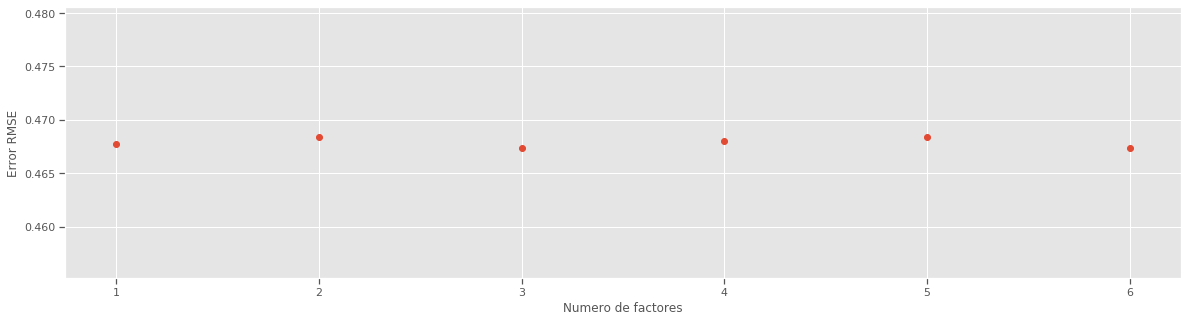

In [244]:
plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

Observamos que el número de factores idoneo para nuestro modelo son 3.

recordar que, cuando entrenamos un SVD, estamos usando descenso por gradiente para minimizar una función de costo. Usar GridSearchCV para buscar valores óptimos para los siguientes parámetros (tres por parámetros, utilizar los valores default de referencia): n_factors, n_epochs, lr_all y reg_all

In [250]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_epochs': [5, 10, 15, 20, 25 ,30, 35], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6], 'n_factors' :[1,2,3,4,5,6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs = -1)

gs.fit(data)


In [251]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.4598760030703428
{'n_epochs': 35, 'lr_all': 0.005, 'reg_all': 0.4, 'n_factors': 1}


In [252]:
params = gs.best_params['rmse']

In [253]:
svdtuned = SVD(n_factors=params['n_factors'], n_epochs=params['n_epochs'],lr_all=params['lr_all'], reg_all=params['reg_all'])

In [254]:
svdtuned.fit(trainset)

In [255]:
predictions_opt = svdtuned.test(testset)

In [256]:
accuracy.rmse(predictions_opt, verbose=True)

RMSE: 0.4591


0.45906612074775494

In [257]:
recomendaciones_usuario2['Estimate_Score_Opt'] = recomendaciones_usuario2['product_id'].apply(lambda x: svdtuned.predict(usuario, x).est)

In [258]:
recomendaciones_usuario2.head()

,index,product_id,title,genres,price,specs,Estimate_Score,Estimate_Score_Opt
0,0,761140,Lost Summoner Kitty,"[Action, Casual, Indie, Simulation, Strategy]",4.99,[Single-player],4.225111,4.272519
21419,21419,530200,Paranormal Island,NaN,3.99,[Captions available],4.225111,4.272519
21432,21432,462680,BalanCity,"[Casual, Indie, Simulation, Strategy]",7.99,[Single-player],4.225111,4.272519
21431,21431,518690,Seventh Knight PC Security + Gaming Accelerator 2,[Utilities],34.99,NaN,4.225111,4.272519
21430,21430,513460,Agenda,"[Indie, Simulation, Strategy, Early Access]",9.99,"[Single-player, Steam Achievements, Steam Trad...",4.225111,4.272519


Observamos que luego de optimizar parametros del algoritmo SVD el score de estimación aumenta un poco reafirmando las previas recomendaciones realizadas al usuario. Observamos que el RMSE tambien mejoró. Este último es mi modelo elegido, es un modelo no tan complejo, optimo y muy preciso. Incluso sin mirar el score al observar las peliculas bien calificadas por el usuario y las sugeridas observamos que hay un alto grado de compatibilidad. Estoy satisfecho con la exploración, transformación y modelado de mi algoritmo, los resultados para mi han sido mejor de los esperado, y personalmente al iniciar este proyecto sinceramente no sabia por donde comenzar pero al ir avanzando el panorama fue siendo más claro, ahora si puedo decir que tengo las bases suficientes para implementar un sistema de recomendación, seguramente en el camino vendrán muchas más cosas por aprender.

### Parte C - Investigación. 
Las preguntas y cosas para probar nunca se agotan. El objetivo de esta sección es que sugieras cómo continuarías el proyecto, con el fin de mejorar el modelo o responder una pregunta que consideres interesante. En todos los notebooks dejamos algunas sugerencias, pero puedes proponer otras.

Aquí debajo encontrarás el notebook con las consignas y el dataset para cada caso. Ten en cuenta que este proyecto se monta sobre los proyectos anteriores, y que ya esperamos cierto grado de independencia de parte tuya. Por eso, las consignas y recomendaciones de los notebooks no son exhaustivas. Es decir, si hay un paso en el flujo de trabajo que no está mencionado en el notebook que te dejamos, no implica que no haya que hacerlo. Recuerda que para ver lo que sí tiene que estar sin falta en tu entregable debes consultar el Checklist.

#### Checklist de evaluación

Debes explicar qué te gustaría probar, por qué y cómo lo harías. Si tienes referencias (por ejemplo, un artículo que hayas encontrado, capítulo de libro, etc.), debes mencionarlas.

Debes comentar también qué resultados esperas encontrar. Por ejemplo, puedes implementar una prueba rápida y mostrar resultados preliminares, para ver si estás correctamente orientado.

El proyecto de sistemas de recomendación ha sido muy valioso en terminos de aprendizaje, como sugerencia o idea para seguir mejorando el proyecto y sus resultados se me ocurren dos cosas. La primera es hacer un split de la columna genero para identificar claramente el genero de la pelicula y este sea un dato significativo y de más facil analisis. La otra idea es referente a aplicar uno de los temas vistos en clase y es referente al analisis del lenguaje natural, lo anterior a fin de analizar las opiniones que tenemos de los juegos por parte de los usuarios en nuestro data set, de tal forma de identificar si la opinion es negativa o positiva y lograr que esta sea relevante para sugerir al usuario nuevos juegos.

In [261]:
df_ml

,title,genres,price,product_id,Rating,username,hours,text
1,Carmageddon Max Pack,"['Action', 'Indie', 'Racing']",9.99,282010,4.5,Hit_Pepns,6.1,"A legend. The game, which in nice, immaculate ..."
2,Carmageddon Max Pack,"['Action', 'Indie', 'Racing']",9.99,282010,4.5,rohonnag,2.7,This game has nostalgia written all over it! I...
124,Disciples II: Rise of the Elves,['Strategy'],6.99,1630,4.5,Executor,5.7,Remains a very nice game . But is still useles...
125,Disciples II: Rise of the Elves,['Strategy'],6.99,1630,4.5,Sir Ronald Doge II,0.3,"ok i bought this game and just installed it, b..."
126,Disciples II: Rise of the Elves,['Strategy'],6.99,1630,4.5,The Denizen,0.3,My friend says it's a good game so why not.
...,...,...,...,...,...,...,...,...
77667,Unreal Tournament 2004: Editor's Choice Edition,['Action'],14.99,13230,5.0,Vardy,28.3,I have played over 5000 hours in this game sin...
77668,Unreal Tournament 2004: Editor's Choice Edition,['Action'],14.99,13230,5.0,Captain Otter,1.9,♥♥♥♥ yeah. UT.
77669,Unreal Tournament 2004: Editor's Choice Edition,['Action'],14.99,13230,5.0,LukeTerrance,2.0,One of the greatest games of all time no auto ...
77670,Unreal Tournament 2004: Editor's Choice Edition,['Action'],14.99,13230,5.0,Schneewittchen,0.5,it's a classic ut with well-looking graphics (...


In [268]:
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
#Esto sirve para configurar NLTK. La primera vez puede tardar un poco
nltk.download('punkt')
nltk.download('stopwords')

# Traemos nuevamente las stopwords
from nltk.corpus import stopwords 
# Importamos el lemmatizar de NLTK, y creamos el objeto
from nltk.stem import WordNetLemmatizer
# Importamos esta libreria que nos permite reemplzar caracteres
import re
import pandas as pd
import json

wordnet_lemmatizer = WordNetLemmatizer()

stopwords = set(stopwords.words('english')) 

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Sammy\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sammy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sammy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sammy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [262]:
df_opiniones =df_ml['text']

In [263]:
df_opiniones

1        A legend. The game, which in nice, immaculate ...
2        This game has nostalgia written all over it! I...
124      Remains a very nice game . But is still useles...
125      ok i bought this game and just installed it, b...
126            My friend says it's a good game so why not.
                               ...                        
77667    I have played over 5000 hours in this game sin...
77668                                       ♥♥♥♥ yeah. UT.
77669    One of the greatest games of all time no auto ...
77670    it's a classic ut with well-looking graphics (...
77671                                 ofc, best game ever.
Name: text, Length: 25549, dtype: object

In [264]:
type(df_opiniones)

pandas.core.series.Series

In [270]:
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [271]:
titular_list=[]
for titular in df_ml['text']:
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    titular=re.sub("[^a-zA-Z]"," ",str(titular))
    # Pasamos todo a minúsculas
    titular=titular.lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    titular = tokenizer.tokenize(titular) # Tokenizar con RegexpTokenizer
    
    # Aplicamos el Lemmatizer (Esto puede tardar un ratito)
    frase_lemma = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in titular]
    
    # Eliminamos las palabras de menos de 3 letras
    titular = [palabra for palabra in frase_lemma if len(palabra)>3]
    
    # Sacamos las Stopwords
    titular = [w for w in titular if not w in stopwords] 
        
    # Por ultimo volvemos a unir el titular
    titular=" ".join(titular)
    #dataset["titular_normalizado"] = titular_list
    titular_list.append(titular)     

In [272]:
df_ml["text_lemm"] = titular_list
df_ml.tail()

,title,genres,price,product_id,Rating,username,hours,text,text_lemm
77667,Unreal Tournament 2004: Editor's Choice Edition,['Action'],14.99,13230,5.0,Vardy,28.3,I have played over 5000 hours in this game sin...,played hour game since release start vehicle c...
77668,Unreal Tournament 2004: Editor's Choice Edition,['Action'],14.99,13230,5.0,Captain Otter,1.9,♥♥♥♥ yeah. UT.,yeah
77669,Unreal Tournament 2004: Editor's Choice Edition,['Action'],14.99,13230,5.0,LukeTerrance,2.0,One of the greatest games of all time no auto ...,great game time auto skill must
77670,Unreal Tournament 2004: Editor's Choice Edition,['Action'],14.99,13230,5.0,Schneewittchen,0.5,it's a classic ut with well-looking graphics (...,classic well look graphic available play spend...
77671,Unreal Tournament 2004: Editor's Choice Edition,['Action'],14.99,13230,5.0,vibeZ,135.8,"ofc, best game ever.",best game ever


Analizar el sentimiento

Ahora nos toca sacarle partido a las herramientas de análisis de sentimiento de NLTK descargadas anteriormente, para lo cual vamos a examinar cada una de las frases por separado. Primero vamos a hacer todos los imports de los elementos que se van a usar.

In [273]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import sentiment
from nltk import word_tokenize

Ahora crearemos el analizador de sentimientos.



In [274]:
analizador = SentimentIntensityAnalyzer()


In [277]:

for sentence in df_ml['text'].head(10):
    print(sentence)
    scores = analizador.polarity_scores(sentence)
    for key in scores:
        print(key, ': ', scores[key])            
        
   

A legend. The game, which in nice, immaculate world wouldn´t have a chance to success. Luckily, we live in this world.
Works like a charm on a strong machine, 3DFX version runs great here too. Really not dissapointed for buying  Carmageddon Reincarnation early access and got first three carmas for free.
neg :  0.0
neu :  0.578
pos :  0.422
compound :  0.9792
This game has nostalgia written all over it! I have loved this game since 1997 and still do, I play it on my iPad more now, coz the grpahics in it are pretty sweet and much better than the pixelled PC version...
but for those who havent played it before, BE WARNED, this is NOT a car racing game, this is a destruction game with cars.
P.s : buying carmageddon reincarnation gives you this game for free. that game is prelaunch now, highly recommend buying that...
neg :  0.112
neu :  0.703
pos :  0.184
compound :  0.646
Remains a very nice game . But is still useless playinh it on steam because the multiplayer does not works. gg steam
n

Con las dos herramientas anteriores ya podriamos dar un score complementario a la valoración de los usuarios y ser más precisos a la hora de hacer nuestras recomendaciones.

### GitHub

==[IDE]== 15-dic-2020 8:29:05 Validating destination...
==[IDE]== 15-dic-2020 8:29:05 Validating destination... finished.
==[IDE]== 15-dic-2020 8:29:05 Cloning
git init F:\Anaconda3\dsOnline25
git fetch https://github.com/sammycabrera/dsOnline25.git +refs/heads/master:refs/remotes/origin/master
Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Branch  : origin/master
Old Id : null
New Id : 54e44354b351d6863ba2390ef3910f797a2a44d3
Result : NEW

setting up remote: origin
git branch --track master origin/master
git checkout master
git reset --hard master
git submodule status
==[IDE]== 15-dic-2020 8:29:07 Cloning finished.
==[IDE]== 15-dic-2020 8:29:34 Ignoring...
ignoring F:\Anaconda3\dsOnline25\Proyecto3\nbproject\private 
Proyecto3/nbproject/private
==[IDE]== 15-dic-2020 8:29:34 Ignoring... finished.
==[IDE]== 15-dic-2020 8:31:43 Committing...
Git Commit
----------
git add F:\Anaconda3\dsOnline25\Proyecto3\Proyectos\DS_Proyecto_03_SR.ipynb 
git commit -m Comprometer proyecto 3 F:\Anaconda3\dsOnline25\Proyecto3\Proyectos\DS_Proyecto_03_SR.ipynb
Commit Log
revision   : 372f9d4a07e3071360e5146084ccbfb507788327
author     : sammycabrera <sammy_cabrera@hotmail.com>
date       : 15-dic-2020 8:31:44
summary    : Comprometer proyecto 3

INFO: End of Commit

==[IDE]== 15-dic-2020 8:31:45 Committing... finished.
==[IDE]== 15-dic-2020 8:31:55 Pushing - dsOnline25
git branch
git remote -v
setting up remote: origin
git submodule status
git push https://sammy_cabrera%40hotmail.com@github.com/sammycabrera/dsOnline25.git refs/heads/master:refs/heads/master

Remote Repository Updates
Branch Update : master
Old Id        : 54e44354b351d6863ba2390ef3910f797a2a44d3
New Id        : 372f9d4a07e3071360e5146084ccbfb507788327
Result        : OK
Show changes in [Search History] or as [Diff]



==[IDE]== 15-dic-2020 8:32:00 Pushing - dsOnline25 finished.

https://github.com/sammycabrera/dsOnline25/blob/master/Proyecto3/Proyectos/DS_Proyecto_03_SR.ipynb